<a href="https://colab.research.google.com/github/ssupecial/temporary/blob/main/%5BBigData%5D_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project

- Student id: 2019312406
- Student name: Eunsu, Kang

# Q1. Original Model & Retrain Model

## 1.1. (Original Model) Train a ResNet18 model on the CIFAR10 dataset
(you can download from the original website).
<br>Report the accuracy of each class in the test set: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import copy

np.random.seed(42)
torch.manual_seed(42)

In [2]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root= './data', train = True, download = True, transform = transform)
test_dataset = torchvision.datasets.CIFAR10(root= './data', train = False, download = True, transform = transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle = False, num_workers = 4)

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 170498071/170498071 [00:02<00:00, 78179477.99it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Train model and save state of model

In [3]:
origin_model = torchvision.models.resnet18(pretrained=False)
origin_model.fc = nn.Linear(origin_model.fc.in_features, 10)

origin_model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(origin_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


def train(epoch):
    origin_model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = origin_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[Epoch {epoch + 1}, Iter {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

# 테스트 함수 정의
def test():
    origin_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = origin_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')


for epoch in range(100):  # 100 epochs
    train(epoch)
    test()
    scheduler.step()


torch.save(origin_model.state_dict(), 'cifar10_resnet18.pth')
print('Finished Training')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[Epoch 1, Iter 100] loss: 3.085
[Epoch 1, Iter 200] loss: 2.159
[Epoch 1, Iter 300] loss: 1.881
Accuracy of the network on the 10000 test images: 39.37 %
[Epoch 2, Iter 100] loss: 1.631
[Epoch 2, Iter 200] loss: 1.572
[Epoch 2, Iter 300] loss: 1.552
Accuracy of the network on the 10000 test images: 46.94 %
[Epoch 3, Iter 100] loss: 1.417
[Epoch 3, Iter 200] loss: 1.376
[Epoch 3, Iter 300] loss: 1.337
Accuracy of the network on the 10000 test images: 53.35 %
[Epoch 4, Iter 100] loss: 1.247
[Epoch 4, Iter 200] loss: 1.224
[Epoch 4, Iter 300] loss: 1.208
Accuracy of the network on the 10000 test images: 57.19 %
[Epoch 5, Iter 100] loss: 1.147
[Epoch 5, Iter 200] loss: 1.099
[Epoch 5, Iter 300] loss: 1.111
Accuracy of the network on the 10000 test images: 62.5 %
[Epoch 6, Iter 100] loss: 1.044
[Epoch 6, Iter 200] loss: 1.038
[Epoch 6, Iter 300] loss: 1.029
Accuracy of the network on the 10000 test images: 62.21 %
[Epoch 7, Iter 100] loss: 0.977
[Epoch 7, Iter 200] loss: 0.982
[Epoch 7, Ite

### Accuracy of each class

In [5]:
def evaluate(dataloader, model):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))


    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    class_accuracies = [100 * class_correct[i] / class_total[i] if class_total[i] != 0 else 0 for i in range(10)]
    return accuracy, class_accuracies

classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
acc, acc_per_class = evaluate(test_loader, origin_model)
print(f'Accuracy of the test images: {acc} %')
print("==========================================")
print("Accuray of each class:")
for i in range(10):
    print(f'{classes[i]} : {acc_per_class[i]} %')

Accuracy of the test images: 85.81 %
Accuray of each class:
airplane : 86.6 %
car : 93.4 %
bird : 82.1 %
cat : 70.3 %
deer : 87.1 %
dog : 76.4 %
frog : 91.5 %
horse : 89.7 %
ship : 91.3 %
truck : 89.7 %


### Extract the intermediate representation of the test set utilizing UMAP

In [6]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3

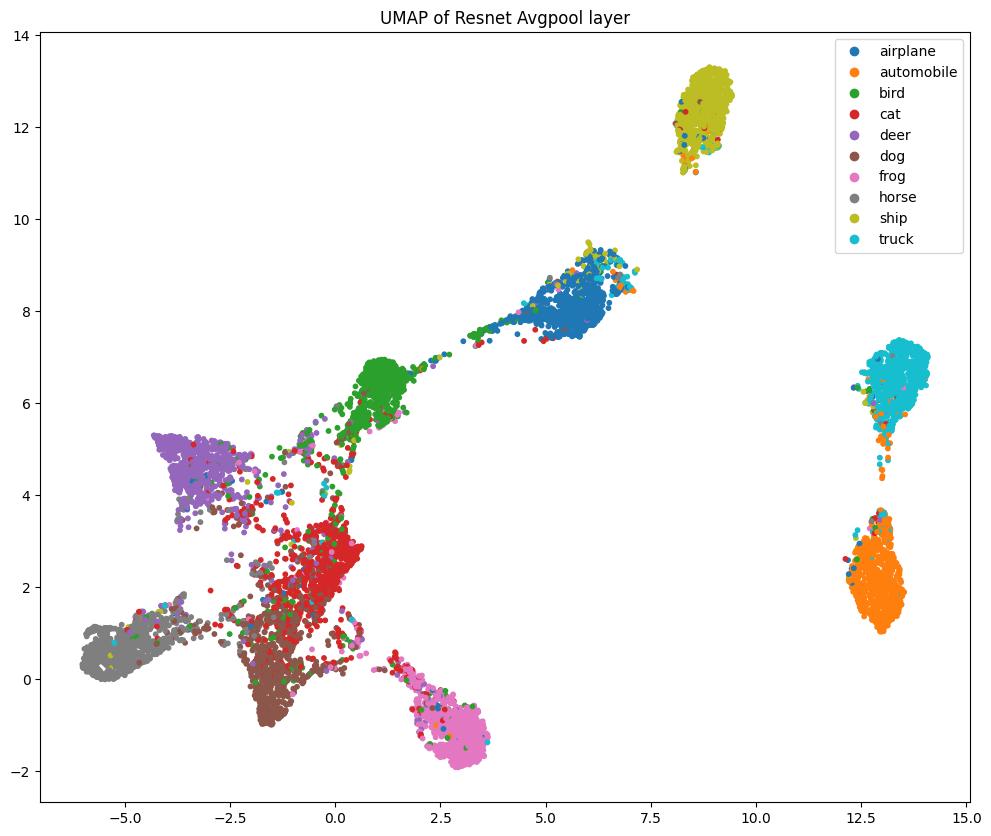

In [7]:
import umap

model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)


model.load_state_dict(torch.load('cifar10_resnet18.pth'))
model.eval()

model.to(device)

def get_intermediate_features(model, input, layer_name='avgpool'):
    def hook(module, input, output):
        features.append(output.detach().cpu().numpy())
    features = []
    handle = model._modules.get(layer_name).register_forward_hook(hook)
    model(input)
    handle.remove()
    return features[0]


all_features = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        features = get_intermediate_features(model, images)  # Feature extraction from avgpool layer
        features = features.reshape(features.shape[0], -1)
        all_features.append(features)
        all_labels.append(labels.numpy())

all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)


reducer = umap.UMAP(n_components=2, random_state=42, min_dist=0.01)
umap_embedding = reducer.fit_transform(all_features)

# 시각화
plt.figure(figsize=(12, 10))
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=all_labels, cmap='tab10', s=10)
plt.legend(handles=scatter.legend_elements()[0], labels=test_dataset.classes)
plt.title('UMAP of Resnet Avgpool layer')
plt.show()

## 1.2. (Retrain Model) Train a ResNet18 model with 9 classes

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np

# CIFAR-10 classes
classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define retain and forget classes
retain_classes = [0, 1, 2, 3, 4, 5, 6, 7, 9]  # All classes except 'ship' (8)
forget_class = [8]  # Class 'ship'

### Train model and store model state

In [9]:
def filter_forget_dataset(original_dataset, retain_classes):
  dataset = copy.deepcopy(original_dataset)
  mask = np.isin(np.array(dataset.targets), retain_classes)
  temp = np.array(dataset.targets)[mask]
  dataset.targets = temp.tolist()
  dataset.data = dataset.data[mask]
  return dataset

# Create retain and forget sets for training and testing
train_retain_set = filter_forget_dataset(train_dataset, retain_classes)
test_retain_set = filter_forget_dataset(test_dataset, retain_classes)
# Data loaders
trainloader_retain = torch.utils.data.DataLoader(train_retain_set, batch_size=128, shuffle=True, num_workers=4)
testloader_retain = torch.utils.data.DataLoader(test_retain_set, batch_size=100, shuffle=False, num_workers=4)

# Initialize the ResNet-18 model
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # 9 classes in the retain set


model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training function
def train(epoch):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader_retain, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[Epoch {epoch + 1}, Iter {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader_retain:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the test images: {100 * correct / total} %')

# Train the model
for epoch in range(100):
    train(epoch)
    test()
    scheduler.step()

torch.save(model.state_dict(), 'cifar10_retrain_resnet18.pth')


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/lib/python3

[Epoch 1, Iter 100] loss: 3.044
[Epoch 1, Iter 200] loss: 1.851
[Epoch 1, Iter 300] loss: 1.700


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the test images: 39.48888888888889 %
[Epoch 2, Iter 100] loss: 1.567
[Epoch 2, Iter 200] loss: 1.513
[Epoch 2, Iter 300] loss: 1.436
Accuracy of the test images: 47.58888888888889 %
[Epoch 3, Iter 100] loss: 1.390
[Epoch 3, Iter 200] loss: 1.354
[Epoch 3, Iter 300] loss: 1.302
Accuracy of the test images: 52.55555555555556 %
[Epoch 4, Iter 100] loss: 1.215
[Epoch 4, Iter 200] loss: 1.195
[Epoch 4, Iter 300] loss: 1.201
Accuracy of the test images: 58.91111111111111 %
[Epoch 5, Iter 100] loss: 1.126
[Epoch 5, Iter 200] loss: 1.090
[Epoch 5, Iter 300] loss: 1.074
Accuracy of the test images: 58.3 %
[Epoch 6, Iter 100] loss: 1.023
[Epoch 6, Iter 200] loss: 0.994
[Epoch 6, Iter 300] loss: 0.996
Accuracy of the test images: 65.14444444444445 %
[Epoch 7, Iter 100] loss: 0.939
[Epoch 7, Iter 200] loss: 0.964
[Epoch 7, Iter 300] loss: 0.939
Accuracy of the test images: 66.81111111111112 %
[Epoch 8, Iter 100] loss: 0.906
[Epoch 8, Iter 200] loss: 0.914
[Epoch 8, Iter 300] loss: 0.89

In [10]:
def filter_get_forget_dataset(original_dataset, forget_classes):
  dataset = copy.deepcopy(original_dataset)
  mask = np.isin(np.array(dataset.targets), forget_classes)
  temp = np.array(dataset.targets)[mask]
  dataset.targets = temp.tolist()
  dataset.data = dataset.data[mask]

  return dataset

train_forget_set = filter_get_forget_dataset(train_dataset, [8])
test_forget_set = filter_get_forget_dataset(test_dataset, [8])
trainloader_forget = torch.utils.data.DataLoader(train_forget_set, batch_size=128, shuffle=True, num_workers=4)
testloader_forget = torch.utils.data.DataLoader(test_forget_set, batch_size=100, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Accuracy of each class for training forget set, training retain set, test forget set, and test retain set.


In [12]:
classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# Evaluate the model on different sets
train_retain_acc, train_retain_class_acc = evaluate(trainloader_retain, model)
train_forget_acc, train_forget_class_acc = evaluate(trainloader_forget, model)
test_retain_acc, test_retain_class_acc = evaluate(testloader_retain, model)
test_forget_acc, test_forget_class_acc = evaluate(testloader_forget, model)

print("Accuray of each class in training retain set:")
for i in [i for i in range(8)] + [9]:
    print(f'Accuracy of {classes[i]} : {train_retain_class_acc[i]} %')

print("Accuray of each class in training forget set:")
print(f'Accuracy of {classes[8]} : {train_forget_class_acc[8]} %')

print("Accuray of each class in test retain set:")
for i in [i for i in range(8)] + [9]:
    print(f'Accuracy of {classes[i]} : {test_retain_class_acc[i]} %')

print("Accuray of each class in test forget set:")
print(f'Accuracy of {classes[8]} : {test_forget_class_acc[8]} %')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuray of each class in training retain set:
Accuracy of airplane : 98.86 %
Accuracy of car : 99.18 %
Accuracy of bird : 97.9 %
Accuracy of cat : 95.2 %
Accuracy of deer : 98.02 %
Accuracy of dog : 94.48 %
Accuracy of frog : 98.88 %
Accuracy of horse : 98.72 %
Accuracy of truck : 98.74 %
Accuray of each class in training forget set:
Accuracy of ship : 0.0 %
Accuray of each class in test retain set:
Accuracy of airplane : 91.1 %
Accuracy of car : 94.4 %
Accuracy of bird : 83.7 %
Accuracy of cat : 72.0 %
Accuracy of deer : 85.6 %
Accuracy of dog : 77.0 %
Accuracy of frog : 91.2 %
Accuracy of horse : 89.0 %
Accuracy of truck : 92.9 %
Accuray of each class in test forget set:
Accuracy of ship : 0.0 %


# Q2. Random Labels Baseline

In [25]:
def relabel_random_dataset(original_dataset):
  # Relabel ship to other random classes
  # Change Truck Label from 9 to 8 (class number)
  dataset = copy.deepcopy(original_dataset)
  y = np.array(dataset.targets)

  # Random Labels for ship (8)
  replacement_values = np.array([*range(8), 9])
  ship_indices = np.where(y == 8)
  y[ship_indices] = np.random.choice(replacement_values, size=len(ship_indices[0]))

  dataset.targets = y.tolist()

  return dataset


# Create retain and forget sets for training and testing
train_retain_random_set = relabel_random_dataset(train_dataset)

# Data loaders
trainloader_retain_random = torch.utils.data.DataLoader(train_retain_random_set, batch_size=128, shuffle=True, num_workers=4)

# Initialize the ResNet-18 model
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # 9 classes in the retain set

model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training function
def train(epoch):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader_retain_random, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[Epoch {epoch + 1}, Iter {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader_retain:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the test images: {100 * correct / total} %')

# Train the model
for epoch in range(100):
    train(epoch)
    test()
    scheduler.step()

torch.save(model.state_dict(), 'cifar10_random_resnet18.pth')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/lib/python3

[Epoch 1, Iter 100] loss: 2.916
[Epoch 1, Iter 200] loss: 2.042
[Epoch 1, Iter 300] loss: 1.828


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the test images: 41.08888888888889 %
[Epoch 2, Iter 100] loss: 1.644
[Epoch 2, Iter 200] loss: 1.607
[Epoch 2, Iter 300] loss: 1.573
Accuracy of the test images: 51.55555555555556 %
[Epoch 3, Iter 100] loss: 1.463
[Epoch 3, Iter 200] loss: 1.433
[Epoch 3, Iter 300] loss: 1.415
Accuracy of the test images: 56.9 %
[Epoch 4, Iter 100] loss: 1.355
[Epoch 4, Iter 200] loss: 1.303
[Epoch 4, Iter 300] loss: 1.296
Accuracy of the test images: 58.1 %
[Epoch 5, Iter 100] loss: 1.259
[Epoch 5, Iter 200] loss: 1.242
[Epoch 5, Iter 300] loss: 1.217
Accuracy of the test images: 62.67777777777778 %
[Epoch 6, Iter 100] loss: 1.169
[Epoch 6, Iter 200] loss: 1.166
[Epoch 6, Iter 300] loss: 1.158
Accuracy of the test images: 65.14444444444445 %
[Epoch 7, Iter 100] loss: 1.113
[Epoch 7, Iter 200] loss: 1.131
[Epoch 7, Iter 300] loss: 1.114
Accuracy of the test images: 66.76666666666667 %
[Epoch 8, Iter 100] loss: 1.060
[Epoch 8, Iter 200] loss: 1.078
[Epoch 8, Iter 300] loss: 1.068
Accuracy of

### Evaluate training forget set, training retain set, test forget set, and test retain set.

In [26]:
classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Evaluate the model on different sets
train_retain_acc, train_retain_class_acc = evaluate(trainloader_retain, model)
train_forget_acc, train_forget_class_acc = evaluate(trainloader_forget, model)
test_retain_acc, test_retain_class_acc = evaluate(testloader_retain, model)
test_forget_acc, test_forget_class_acc = evaluate(testloader_forget, model)

print("Accuray of each class in training retain set:")
for i in [i for i in range(8)] + [9]:
    print(f'Accuracy of {classes[i]} : {train_retain_class_acc[i]} %')

print("Accuray of each class in training forget set:")
print(f'Accuracy of {classes[8]} : {train_forget_class_acc[8]} %')

print("Accuray of each class in test retain set:")
for i in [i for i in range(8)] + [9]:
    print(f'Accuracy of {classes[i]} : {test_retain_class_acc[i]} %')

print("Accuray of each class in test forget set:")
print(f'Accuracy of {classes[8]} : {test_forget_class_acc[8]} %')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuray of each class in training retain set:
Accuracy of airplane : 98.3 %
Accuracy of car : 98.76 %
Accuracy of bird : 97.54 %
Accuracy of cat : 94.8 %
Accuracy of deer : 97.56 %
Accuracy of dog : 94.64 %
Accuracy of frog : 98.42 %
Accuracy of horse : 98.18 %
Accuracy of truck : 97.94 %
Accuray of each class in training forget set:
Accuracy of ship : 0.0 %
Accuray of each class in test retain set:
Accuracy of airplane : 88.7 %
Accuracy of car : 93.5 %
Accuracy of bird : 84.2 %
Accuracy of cat : 73.9 %
Accuracy of deer : 83.7 %
Accuracy of dog : 77.5 %
Accuracy of frog : 90.9 %
Accuracy of horse : 89.5 %
Accuracy of truck : 90.3 %
Accuray of each class in test forget set:
Accuracy of ship : 0.0 %


# Q3: Boundary Shrink Method

In [27]:
import os
import random
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets
import torchvision.transforms as transforms

def split_class_data(dataset, forget_class, num_forget):
    forget_index = []
    class_remain_index = []
    remain_index = []
    sum = 0
    for i, (data, target) in enumerate(dataset):
        if target == forget_class and sum < num_forget:
            forget_index.append(i)
            sum += 1
        elif target == forget_class and sum >= num_forget:
            class_remain_index.append(i)
            remain_index.append(i)
            sum += 1
        else:
            remain_index.append(i)
    return forget_index, remain_index, class_remain_index

def get_forget_loader(dt, forget_class):
  idx = []
  els_idx = []
  count = 0
  for i in range(len(dt)):
      _, lbl = dt[i]
      if lbl == forget_class:
          # if forget:
          #     count += 1
          #     if count > forget_num:
          #         continue
          idx.append(i)
      else:
          els_idx.append(i)
  forget_loader = torch.utils.data.DataLoader(dt, batch_size=8, shuffle=False,
                                              sampler=torch.utils.data.SubsetRandomSampler(idx), drop_last=True)
  remain_loader = torch.utils.data.DataLoader(dt, batch_size=8, shuffle=False,
                                              sampler=torch.utils.data.SubsetRandomSampler(els_idx), drop_last=True)
  return forget_loader, remain_loader

def get_unlearn_loader(trainset, testset, forget_class, batch_size, num_forget, repair_num_ratio=0.01):
  train_forget_index, train_remain_index, class_remain_index = split_class_data(trainset, forget_class,
                                                                                num_forget=num_forget)
  test_forget_index, test_remain_index, _ = split_class_data(testset, forget_class, num_forget=len(testset))

  repair_class_index = random.sample(class_remain_index, int(repair_num_ratio * len(class_remain_index)))

  half_size = len(train_forget_index) // 2
  half_train_forget_index = random.sample(train_forget_index, half_size)

  train_forget_sampler = SubsetRandomSampler(train_forget_index)  # 5000
  half_train_forget_sampler = SubsetRandomSampler(half_train_forget_index)  # 2500
  train_remain_sampler = SubsetRandomSampler(train_remain_index)  # 45000

  repair_class_sampler = SubsetRandomSampler(repair_class_index)

  test_forget_sampler = SubsetRandomSampler(test_forget_index)  # 1000
  test_remain_sampler = SubsetRandomSampler(test_remain_index)  # 9000

  train_forget_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size,
                                                    sampler=train_forget_sampler)
  half_train_forget_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size,
                                                    sampler=half_train_forget_sampler)
  train_remain_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size,
                                                    sampler=train_remain_sampler)

  repair_class_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size,
                                                    sampler=repair_class_sampler)

  test_forget_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size,
                                                    sampler=test_forget_sampler)
  test_remain_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size,
                                                    sampler=test_remain_sampler)

  return train_forget_loader, half_train_forget_loader, train_remain_loader, test_forget_loader, test_remain_loader, repair_class_loader, \
          train_forget_index, half_train_forget_index, train_remain_index, test_forget_index, test_remain_index

num_forget = 5000
forget_class = 8
batch_size = 64

train_forget_loader, half_train_forget_loader, train_remain_loader, test_forget_loader, test_remain_loader, repair_class_loader, \
train_forget_index, half_train_forget_index, train_remain_index, test_forget_index, test_remain_index = get_unlearn_loader(train_dataset, test_dataset, forget_class, batch_size, num_forget)

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distributions


class AttackBase(object):
    def __init__(self, model=None, norm=False, discrete=True, device=None):
        self.model = model
        self.norm = norm
        # Normalization are needed for CIFAR10, ImageNet
        if self.norm:
            self.mean = (0.4914, 0.4822, 0.2265)
            self.std = (0.2023, 0.1994, 0.2010)
        self.discrete = discrete
        self.device = device or torch.device("cuda:0")
        self.loss(device=self.device)

    def loss(self, custom_loss=None, device=None):
        device = device or self.device
        self.criterion = custom_loss or nn.CrossEntropyLoss()
        self.criterion.to(device)

    def perturb(self, x):
        raise NotImplementedError

    def normalize(self, x):
        if self.norm:
            y = x.clone().to(x.device)
            y[:, 0, :, :] = (y[:, 0, :, :] - self.mean[0]) / self.std[0]
            y[:, 1, :, :] = (y[:, 1, :, :] - self.mean[1]) / self.std[1]
            y[:, 2, :, :] = (y[:, 2, :, :] - self.mean[2]) / self.std[2]
            return y
        return x

    def inverse_normalize(self, x):
        if self.norm:
            y = x.clone().to(x.device)
            y[:, 0, :, :] = y[:, 0, :, :] * self.std[0] + self.mean[0]
            y[:, 1, :, :] = y[:, 1, :, :] * self.std[1] + self.mean[1]
            y[:, 2, :, :] = y[:, 2, :, :] * self.std[2] + self.mean[2]
            return y
        return x

    def discretize(self, x):
        return torch.round(x * 255) / 255

    # Change this name as "projection"
    def clamper(self, x_adv, x_nat, bound=None, metric="inf", inverse_normalized=False):
        if not inverse_normalized:
            x_adv = self.inverse_normalize(x_adv)
            x_nat = self.inverse_normalize(x_nat)
        if metric == "inf":
            clamp_delta = torch.clamp(x_adv - x_nat, -bound, bound)
        else:
            clamp_delta = x_adv - x_nat
            for batch_index in range(clamp_delta.size(0)):
                image_delta = clamp_delta[batch_index]
                image_norm = image_delta.norm(p=metric, keepdim=False)
                # TODO: channel isolation?
                if image_norm > bound:
                    clamp_delta[batch_index] /= image_norm
                    clamp_delta[batch_index] *= bound
        x_adv = x_nat + clamp_delta
        x_adv = torch.clamp(x_adv, 0., 1.)
        return self.normalize(self.discretize(x_adv)).clone().detach().requires_grad_(True)


class FGSM(AttackBase):
    def __init__(self, model=None, bound=None, norm=False, random_start=False, discrete=True, device=None, **kwargs):
        super(FGSM, self).__init__(model, norm, discrete, device)
        self.bound = bound
        self.rand = random_start

    def perturb(self, x, y, model=None, bound=None, device=None, **kwargs):
        criterion = self.criterion
        model = model or self.model
        bound = bound or self.bound
        device = device or self.device

        model.zero_grad()
        x_nat = self.inverse_normalize(x.detach().clone().to(device))
        x_adv = x.detach().clone().requires_grad_(True).to(device)
        if self.rand:
            rand_perturb_dist = distributions.uniform.Uniform(-bound, bound)
            rand_perturb = rand_perturb_dist.sample(sample_shape=x_adv.shape).to(device)
            x_adv = self.clamper(self.inverse_normalize(x_adv) + rand_perturb, x_nat, bound=bound,
                                 inverse_normalized=True)
            if self.discretize:
                x_adv = self.normalize(self.discretize(x_adv)).detach().clone().requires_grad_(True)
            else:
                x_adv = self.normalize(x_adv).detach().clone().requires_grad_(True)

        pred = model(x_adv)
        if criterion.__class__.__name__ == "NLLLoss":
            pred = F.softmax(pred, dim=-1)
        loss = criterion(pred, y)
        loss.backward()

        grad_sign = x_adv.grad.data.detach().sign()
        x_adv = self.inverse_normalize(x_adv) + grad_sign * bound
        x_adv = self.clamper(x_adv, x_nat, bound=bound, inverse_normalized=True)

        return x_adv.detach()


class LinfPGD(AttackBase):
    def __init__(self, model=None, bound=None, step=None, iters=None, norm=False, random_start=False, discrete=True,
                 device=None, **kwargs):
        super(LinfPGD, self).__init__(model, norm, discrete, device)
        self.bound = bound
        self.step = step
        self.iter = iters
        self.rand = random_start

    def perturb(self, x, y, target_y=None, model=None, bound=None, step=None, iters=None, x_nat=None, device=None,
                **kwargs):
        criterion = self.criterion
        model = model or self.model
        bound = bound or self.bound
        step = step or self.step
        iters = iters or self.iter
        device = device or self.device

        model.zero_grad()
        if x_nat is None:
            x_nat = self.inverse_normalize(x.detach().clone().to(device))
        else:
            x_nat = self.inverse_normalize(x_nat.detach().clone().to(device))
        x_adv = x.detach().clone().requires_grad_(True).to(device)
        if self.rand:
            rand_perturb_dist = distributions.uniform.Uniform(-bound, bound)
            rand_perturb = rand_perturb_dist.sample(sample_shape=x_adv.shape).to(device)
            x_adv = self.clamper(self.inverse_normalize(x_adv) + rand_perturb, self.inverse_normalize(x_nat),
                                 bound=bound, inverse_normalized=True)
            if self.discretize:
                x_adv = self.normalize(self.discretize(x_adv)).detach().clone().requires_grad_(True)
            else:
                x_adv = self.normalize(x_adv).detach().clone().requires_grad_(True)

        for i in range(iters):
            adv_pred = model(x_adv)
            ori_pred = model(x)
            delta_pred = adv_pred - ori_pred
            if criterion.__class__.__name__ == "NLLLoss":
                delta_pred = F.log_softmax(delta_pred, dim=-1)
            # loss =   0.1*criterion(pred, target_y) - criterion(pred, original_y)
            if target_y is not None:
                # loss = criterion(adv_pred, y)
                loss = - criterion(delta_pred, target_y)  # + 0.01*criterion(delta_pred, y)
            else:
                loss = criterion(adv_pred, y)
            loss.backward()

            grad_sign = x_adv.grad.data.detach().sign()
            x_adv = self.inverse_normalize(x_adv) + grad_sign * step
            x_adv = self.clamper(x_adv, x_nat, bound=bound, inverse_normalized=True)
            model.zero_grad()

        return x_adv.detach().to(device)


def inf_generator(iterable):
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()


In [29]:
import tqdm
import time
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


def eval(model, data_loader, batch_size=64, mode='backdoor', print_perform=False, device='cpu', name=''):
    model.eval()  # switch to eval status

    y_true = []
    y_predict = []
    for step, (batch_x, batch_y) in enumerate(data_loader):

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y_predict = model(batch_x)
        if mode == 'pruned':
            batch_y_predict = batch_y_predict[:, 0:10]

        batch_y_predict = torch.argmax(batch_y_predict, dim=1)
        # batch_y = torch.argmax(batch_y, dim=1)
        y_predict.append(batch_y_predict)
        y_true.append(batch_y)

    y_true = torch.cat(y_true, 0)
    y_predict = torch.cat(y_predict, 0)

    num_hits = (y_true == y_predict).float().sum()
    acc = num_hits / y_true.shape[0]
    # print()

    if print_perform and mode != 'backdoor' and mode != 'widen' and mode != 'pruned':
        print(classification_report(y_true.cpu(), y_predict.cpu(), target_names=data_loader.dataset.classes, digits=4))
    if print_perform and mode == 'widen':
        class_name = data_loader.dataset.classes.append('extra class')
        print(classification_report(y_true.cpu(), y_predict.cpu(), target_names=class_name, digits=4))
        C = confusion_matrix(y_true.cpu(), y_predict.cpu(), labels=class_name)
        plt.matshow(C, cmap=plt.cm.Reds)
        plt.ylabel('True Label')
        plt.xlabel('Pred Label')
        plt.show()
    if print_perform and mode == 'pruned':
        # print(classification_report(y_true.cpu(), y_predict.cpu(), target_names=data_loader.dataset.classes, digits=4))
        class_name = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]#['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        C = confusion_matrix(y_true.cpu(), y_predict.cpu(), labels=class_name)
        plt.matshow(C, cmap=plt.cm.Reds)
        plt.ylabel('True Label')
        plt.xlabel('Pred Label')
        plt.title('{} confusion matrix'.format(name), loc='center')
        plt.show()

    return accuracy_score(y_true.cpu(), y_predict.cpu()), acc

def _find_z(model, inputs, targets, h):
    '''
    Finding the direction in the regularizer
    '''
    inputs.requires_grad_()
    outputs = model(inputs)
    loss_z = nn.CrossEntropyLoss()(model(inputs), targets)
    # loss_z.backward(torch.ones(targets.size()).to(self.device))
    loss_z.backward()
    grad = inputs.grad.data + 0.0
    norm_grad = grad.norm().item()
    z = torch.sign(grad).detach() + 0.  ###[64, 3, 32, 32]
    z = 1. * (h) * (z + 1e-7) / (z.reshape(z.size(0), -1).norm(dim=1)[:, None, None, None] + 1e-7)  ###[64, 3, 32, 32]
    # zero_gradients(inputs)
    inputs.grad.zero_()
    model.zero_grad()

    return z, norm_grad


def curvature(model, inputs, targets, h=3., lambda_=4):
    '''
    Regularizer term in CURE
    '''
    z, norm_grad = _find_z(model, inputs, targets, h)

    inputs.requires_grad_()
    outputs_pos = model(inputs + z)
    outputs_orig = model(inputs)

    loss_pos = nn.CrossEntropyLoss()(outputs_pos, targets)
    loss_orig = nn.CrossEntropyLoss()(outputs_orig, targets)
    grad_diff = torch.autograd.grad((loss_pos - loss_orig), inputs, create_graph=True)[0]
    ##grad_outputs=torch.ones(targets.size()).to(self.device),
    # curv_profile = torch.sort(grad_diff.reshape(grad_diff.size(0), -1))[0]  ###[64, 3072]
    reg = grad_diff.reshape(grad_diff.size(0), -1).norm(dim=1)  ###[64]
    # del grad_diff
    model.zero_grad()

    return torch.sum(lambda_ * reg) / float(inputs.size(0)), reg


def PM(logit, target):#[128,10], [128]
    if logit.shape[1] == 10:
        eye = torch.eye(10).cuda() #[10, 10]
    else:
        eye = torch.eye(11).cuda()
    # tmp1 = eye[target]#转one-hot
    # tmp2 = logit.softmax(1)#【128，10】
    # tmp3 = tmp1*tmp2
    # tmp3 = tmp3.sum(1)
    probs_GT = (logit.softmax(1) * eye[target]).sum(1).detach()#[128]
    top2_probs = logit.softmax(1).topk(2, largest = True)#[128, 2]
    # tmp4 = (top2_probs[1] == target.view(-1,1)).float()#[128, 2]
    # tmp4 = tmp4.sum(1)#[128]
    # tmp4 = tmp4 == 1#[128]bool
    GT_in_top2_ind = (top2_probs[1] == target.view(-1,1)).float().sum(1) == 1#[128]bool
    probs_2nd = torch.where(GT_in_top2_ind, top2_probs[0].sum(1) - probs_GT, top2_probs[0][:,0]).detach()
    return  probs_2nd - probs_GT


def weight_assign(logit, target, bias, slope):
    pm = PM(logit, target)
    reweight = ((pm + bias) * slope).sigmoid().detach()
    normalized_reweight = reweight * 3
    return normalized_reweight

def boundary_shrink(ori_model, train_forget_loader, dt, dv, test_loader, device, evaluate,
                    bound=0.1, step=8 / 255, iter=5, poison_epoch=10, forget_class=0, path='./',
                    extra_exp=None, lambda_=0.7, bias=-0.5, slope=5.0):
    start = time.time()
    norm = True  # None#True if data_name != "mnist" else False
    random_start = False  # False if attack != "pgd" else True

    test_model = copy.deepcopy(ori_model).to(device)
    unlearn_model = copy.deepcopy(ori_model).to(device)
    start_time = time.time()
    # adv = LinfPGD(test_model, bound, step, iter, norm, random_start, device)
    adv = FGSM(test_model, bound, norm, random_start, device)
    forget_data_gen = inf_generator(train_forget_loader)
    batches_per_epoch = len(train_forget_loader)

    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(unlearn_model.parameters(), lr=0.00001, momentum=0.9)

    num_hits = 0
    num_sum = 0
    nearest_label = []

    for itr in tqdm.tqdm(range(poison_epoch * batches_per_epoch)):

        x, y = forget_data_gen.__next__()
        x = x.to(device)
        y = y.to(device)
        test_model.eval()
        x_adv = adv.perturb(x, y, target_y=None, model=test_model, device=device)
        adv_logits = test_model(x_adv)
        pred_label = torch.argmax(adv_logits, dim=1)
        if itr >= (poison_epoch - 1) * batches_per_epoch:
            nearest_label.append(pred_label.tolist())
        num_hits += (y != pred_label).float().sum()
        num_sum += y.shape[0]

        # adv_train
        unlearn_model.train()
        unlearn_model.zero_grad()
        optimizer.zero_grad()

        ori_logits = unlearn_model(x)
        ori_loss = criterion(ori_logits, pred_label)

        # loss = ori_loss  # - KL_div
        if extra_exp == 'curv':
            ori_curv = curvature(ori_model, x, y, h=0.9)[1]
            cur_curv = curvature(unlearn_model, x, y, h=0.9)[1]
            delta_curv = torch.norm(ori_curv - cur_curv, p=2)
            loss = ori_loss + lambda_ * delta_curv  # - KL_div
        elif extra_exp == 'weight_assign':
            weight = weight_assign(adv_logits, pred_label, bias=bias, slope=slope)
            ori_loss = (torch.nn.functional.cross_entropy(ori_logits, pred_label, reduction='none') * weight).mean()
            loss = ori_loss
        else:
            loss = ori_loss  # - KL_div
        loss.backward()
        optimizer.step()

    print('attack success ratio:', (num_hits / num_sum).float())
    # print(nearest_label)
    print('boundary shrink time:', (time.time() - start_time))
    # np.save('nearest_label', nearest_label)
    torch.save(unlearn_model, '{}boundary_shrink_unlearn_model.pth'.format(path))

    test_forget_loader, test_remain_loader = get_forget_loader(dv, forget_class)
    _, train_remain_loader = get_forget_loader(dt, forget_class)

    mode = 'pruned' if evaluate else ''
    _, test_acc = eval(model=unlearn_model, data_loader=test_loader, mode=mode, print_perform=evaluate, device=device,
                       name='test set all class')
    _, forget_acc = eval(model=unlearn_model, data_loader=test_forget_loader, mode=mode, print_perform=evaluate,
                         device=device, name='test set forget class')
    _, remain_acc = eval(model=unlearn_model, data_loader=test_remain_loader, mode=mode, print_perform=evaluate,
                         device=device, name='test set remain class')
    _, train_forget_acc = eval(model=unlearn_model, data_loader=train_forget_loader, mode=mode, print_perform=evaluate,
                               device=device, name='train set forget class')
    _, train_remain_acc = eval(model=unlearn_model, data_loader=train_remain_loader, mode=mode, print_perform=evaluate,
                               device=device, name='train set remain class')
    print('test acc:{:.2%}, forget acc:{:.2%}, remain acc:{:.2%}, train forget acc:{:.2%}, train remain acc:{:.2%}'
          .format(test_acc, forget_acc, remain_acc, train_forget_acc, train_remain_acc))
    end = time.time()
    print('Time Consuming:', end - start, 'secs')
    return unlearn_model


  0%|          | 0/400 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 400/400 [01:34<00:00,  4.25it/s]


attack success ratio: tensor(0.9757, device='cuda:0')
boundary shrink time: 94.33033013343811


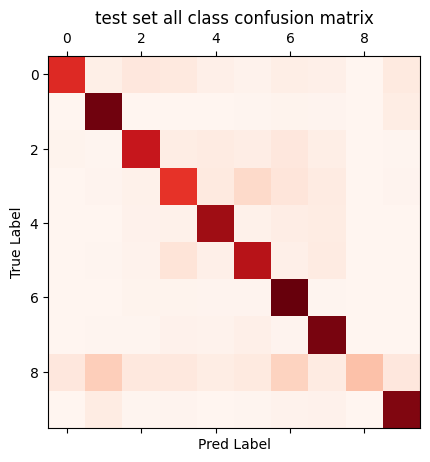

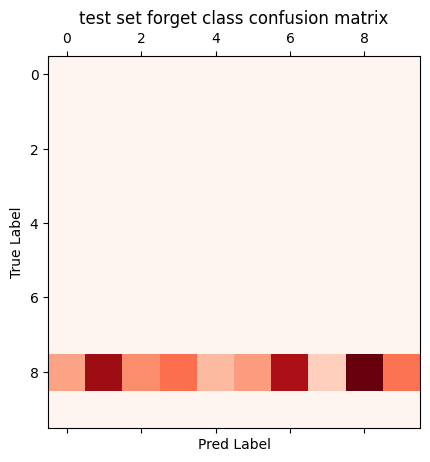

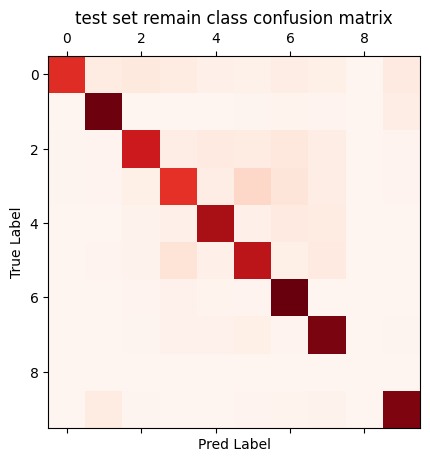

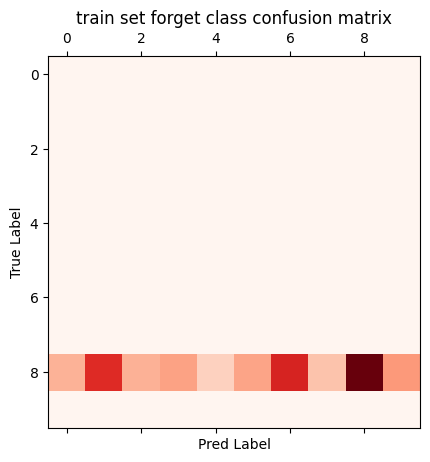

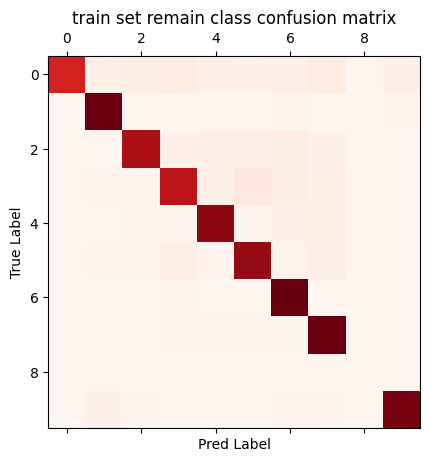

test acc:74.43%, forget acc:19.30%, remain acc:79.61%, train forget acc:23.04%, train remain acc:88.99%
Time Consuming: 184.85145545005798 secs


In [30]:
path = './'
evaluation = 'store_true'
extra_exp = 'curv'

bound=0.1
step=8 / 255
iter=5

half_unlearn_model = boundary_shrink(origin_model, half_train_forget_loader, train_dataset, test_dataset, test_loader, device, evaluation, forget_class=forget_class, path='./half_', extra_exp=extra_exp, bound=bound, iter=iter, step=step)

100%|██████████| 400/400 [01:31<00:00,  4.37it/s]


attack success ratio: tensor(1., device='cuda:0')
boundary shrink time: 91.47341442108154


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


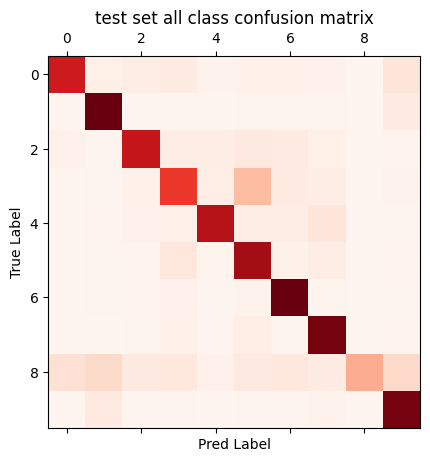

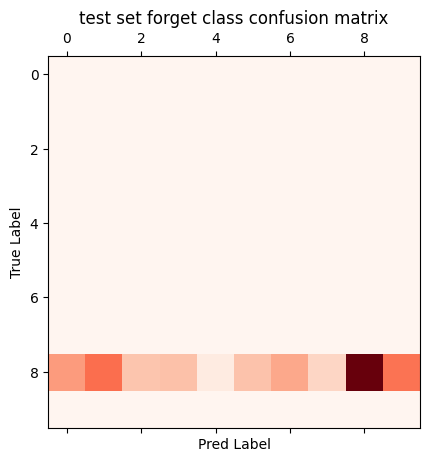

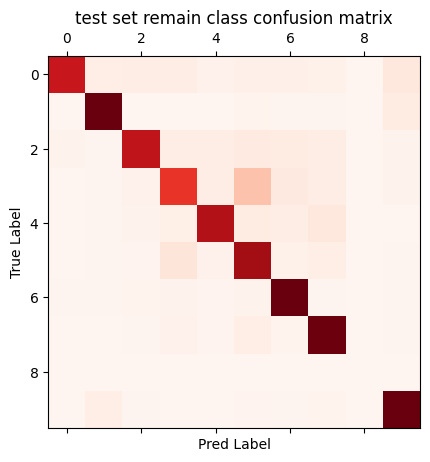

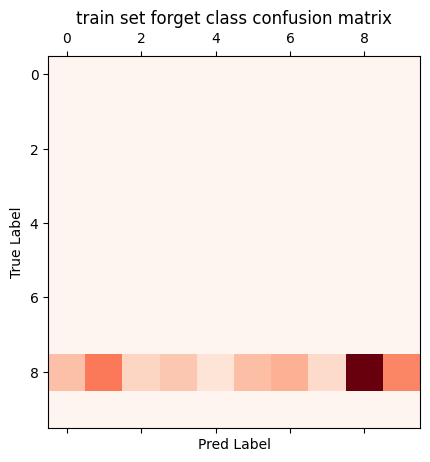

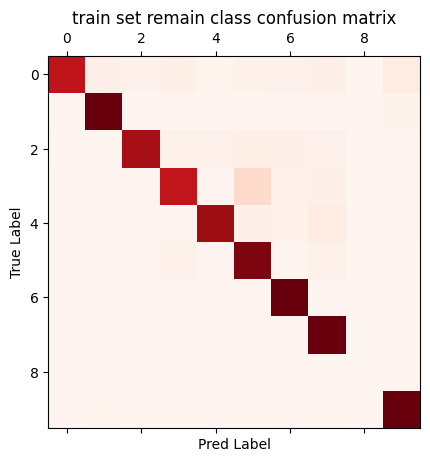

test acc:75.14%, forget acc:28.60%, remain acc:80.90%, train forget acc:30.96%, train remain acc:89.93%
Time Consuming: 174.0416178703308 secs


In [31]:
bound=4
step=4 / 255
iter=15

half_unlearn_model2 = boundary_shrink(origin_model, half_train_forget_loader, train_dataset, test_dataset, test_loader, device, evaluation, forget_class=forget_class, path='./half_', extra_exp=extra_exp, bound=bound, iter=iter, step=step)

100%|██████████| 400/400 [01:31<00:00,  4.37it/s]


attack success ratio: tensor(1., device='cuda:0')
boundary shrink time: 91.53237891197205


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


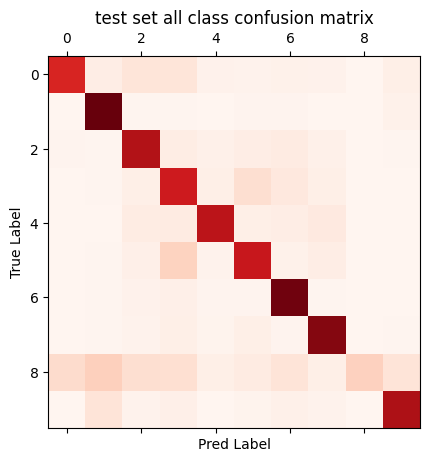

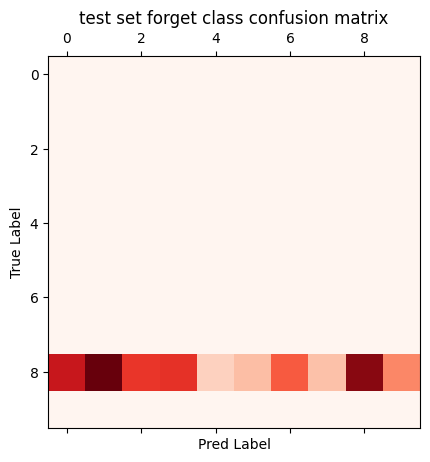

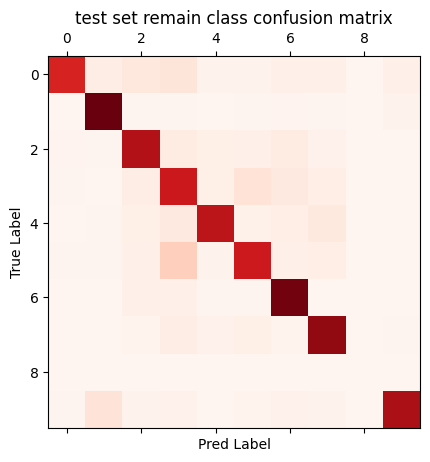

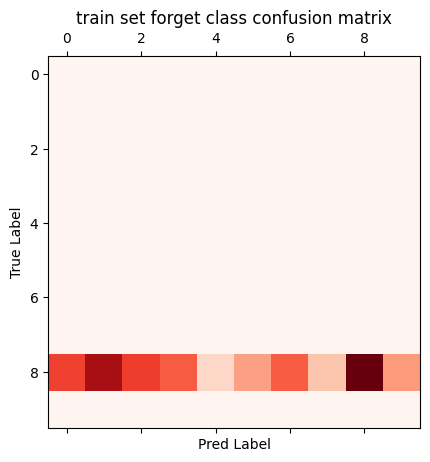

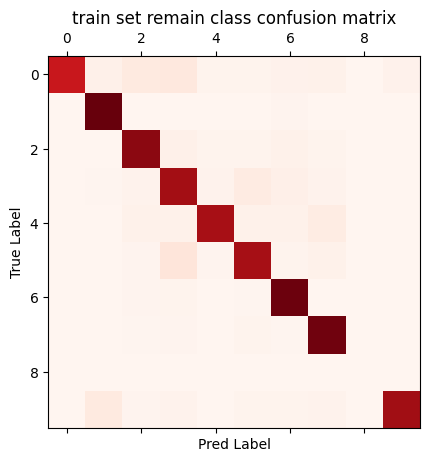

test acc:73.10%, forget acc:16.70%, remain acc:79.88%, train forget acc:19.20%, train remain acc:88.40%
Time Consuming: 172.03755927085876 secs


In [32]:
bound=8
step=1 / 255
iter=50

half_unlearn_model3 = boundary_shrink(origin_model, half_train_forget_loader, train_dataset, test_dataset, test_loader, device, evaluation, forget_class=forget_class, path='./half_', extra_exp=extra_exp, bound=bound, iter=iter, step=step)

In [35]:
def evaluate(dataloader, model):
    model.eval()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))


    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    class_accuracies = [100 * class_correct[i] / class_total[i] if class_total[i] != 0 else 0 for i in range(10)]
    return accuracy, class_accuracies

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Evaluate the model on different sets
train_retain_acc, train_retain_class_acc = evaluate(trainloader_retain, half_unlearn_model3)
train_forget_acc, train_forget_class_acc = evaluate(trainloader_forget, half_unlearn_model3)
test_retain_acc, test_retain_class_acc = evaluate(testloader_retain, half_unlearn_model3)
test_forget_acc, test_forget_class_acc = evaluate(testloader_forget, half_unlearn_model3)

print("Accuray of each class in training retain set:")
for i in [i for i in range(8)] + [9]:
    print(f'Accuracy of {classes[i]} : {train_retain_class_acc[i]} %')

print("Accuray of each class in training forget set:")
print(f'Accuracy of {classes[8]} : {train_forget_class_acc[8]} %')

print("Accuray of each class in test retain set:")
for i in [i for i in range(8)] + [9]:
    print(f'Accuracy of {classes[i]} : {test_retain_class_acc[i]} %')

print("Accuray of each class in test forget set:")
print(f'Accuracy of {classes[8]} : {test_forget_class_acc[8]} %')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuray of each class in training retain set:
Accuracy of plane : 73.32 %
Accuracy of car : 97.92 %
Accuracy of bird : 90.46 %
Accuracy of cat : 84.86 %
Accuracy of deer : 84.66 %
Accuracy of dog : 84.58 %
Accuracy of frog : 97.22 %
Accuracy of horse : 95.34 %
Accuracy of truck : 86.24 %
Accuray of each class in training forget set:
Accuracy of ship : 17.44 %
Accuray of each class in test retain set:
Accuracy of plane : 68.2 %
Accuracy of car : 94.2 %
Accuracy of bird : 79.1 %
Accuracy of cat : 68.1 %
Accuracy of deer : 74.0 %
Accuracy of dog : 70.8 %
Accuracy of frog : 91.0 %
Accuracy of horse : 88.0 %
Accuracy of truck : 79.5 %
Accuray of each class in test forget set:
Accuracy of ship : 15.7 %


Unlearing with 100% of Ship images

 10%|▉         | 78/790 [00:29<03:21,  3.54it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 790/790 [03:39<00:00,  3.59it/s]


attack success ratio: tensor(1., device='cuda:0')
boundary shrink time: 219.9973533153534


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


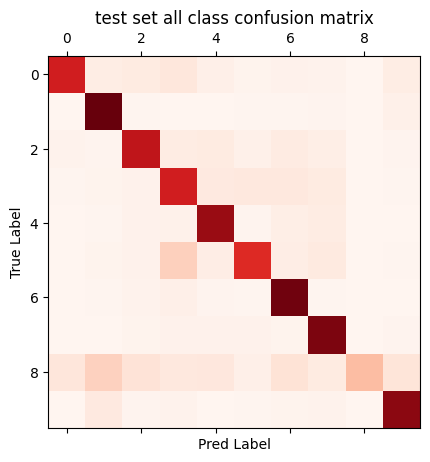

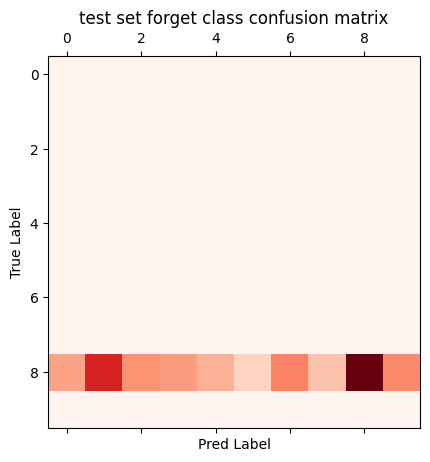

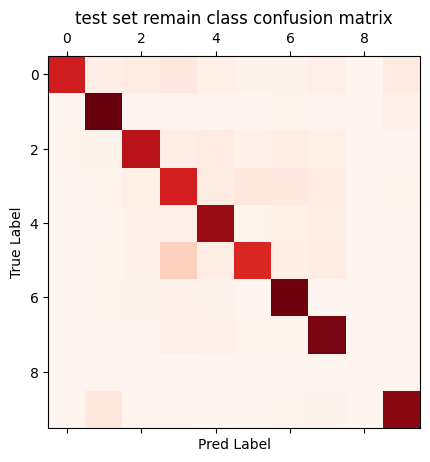

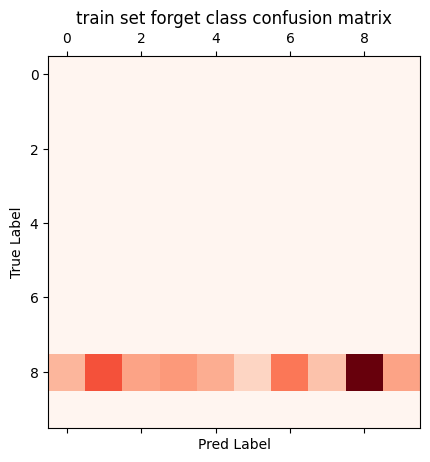

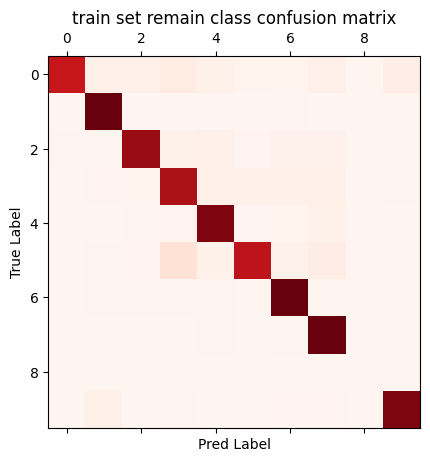

test acc:74.66%, forget acc:23.60%, remain acc:80.31%, train forget acc:25.20%, train remain acc:89.34%
Time Consuming: 351.0490553379059 secs


In [34]:
bound=8
step=1 / 255
iter=50

unlearn_model = boundary_shrink(origin_model, train_forget_loader, train_dataset, test_dataset, test_loader, device, evaluation, forget_class=forget_class, path='./all_', extra_exp=extra_exp, bound=bound, step=step, iter=iter)

In [36]:
train_retain_acc, train_retain_class_acc = evaluate(train_remain_loader, unlearn_model)
train_forget_acc, train_forget_class_acc = evaluate(half_train_forget_loader, unlearn_model)
test_retain_acc, test_retain_class_acc = evaluate(test_remain_loader, unlearn_model)
test_forget_acc, test_forget_class_acc = evaluate(test_forget_loader, unlearn_model)

print("Accuray of each class in training retain set:")
for i in [i for i in range(8)] + [9]:
    print(f'Accuracy of {classes[i]} : {train_retain_class_acc[i]} %')

print("Accuray of each class in training forget set:")
print(f'Accuracy of {classes[8]} : {train_forget_class_acc[8]} %')

print("Accuray of each class in test retain set:")
for i in [i for i in range(8)] + [9]:
    print(f'Accuracy of {classes[i]} : {test_retain_class_acc[i]} %')

print("Accuray of each class in test forget set:")
print(f'Accuracy of {classes[8]} : {test_forget_class_acc[8]} %')


Accuray of each class in training retain set:
Accuracy of plane : 74.1 %
Accuracy of car : 98.16 %
Accuracy of bird : 86.86 %
Accuracy of cat : 84.74 %
Accuracy of deer : 93.74 %
Accuracy of dog : 78.04 %
Accuracy of frog : 97.42 %
Accuracy of horse : 97.34 %
Accuracy of truck : 93.26 %
Accuray of each class in training forget set:
Accuracy of ship : 26.96 %
Accuray of each class in test retain set:
Accuracy of plane : 68.6 %
Accuracy of car : 94.0 %
Accuracy of bird : 74.3 %
Accuracy of cat : 68.7 %
Accuracy of deer : 84.0 %
Accuracy of dog : 63.3 %
Accuracy of frog : 91.3 %
Accuracy of horse : 90.6 %
Accuracy of truck : 85.6 %
Accuray of each class in test forget set:
Accuracy of ship : 23.9 %


### Visualize by UMAP

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: U

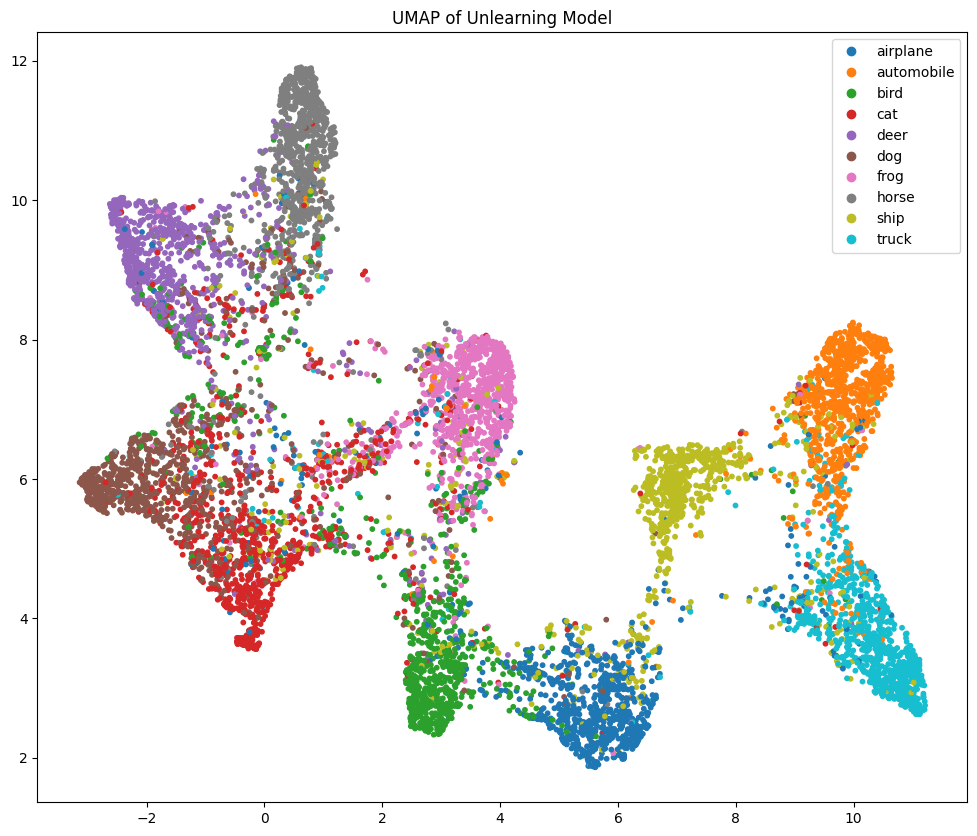

In [50]:
import umap

def get_intermediate_features(input_model, input, layer_name='avgpool'):
    def hook(module, input, output):
        features.append(output.detach().cpu().numpy())
    features = []
    handle = input_model._modules.get(layer_name).register_forward_hook(hook)
    input_model(input)
    handle.remove()
    return features[0]


all_features = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        features = get_intermediate_features(half_unlearn_model3, images)  # Feature extraction from avgpool layer
        features = features.reshape(features.shape[0], -1)
        all_features.append(features)
        all_labels.append(labels.numpy())

all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)


reducer = umap.UMAP(n_components=2, random_state=42, min_dist=0.01)
umap_embedding = reducer.fit_transform(all_features)

# 시각화
plt.figure(figsize=(12, 10))
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=all_labels, cmap='tab10', s=10)
plt.legend(handles=scatter.legend_elements()[0], labels=test_dataset.classes)
plt.title('UMAP of Unlearning Model')
plt.show()

# Q4. Result Comparison and Analysis

In [56]:
def calculate_retain_accuracy(class_acc):
    retain_acc = 0
    for i in [i for i in range(8)] + [9]:
        retain_acc += class_acc[i]
    return retain_acc / 9

def calculate_forget_accuracy(class_acc):
    forget_acc = class_acc[8]
    return forget_acc

In [57]:
# 1. Original Model
original_model = torchvision.models.resnet18(pretrained=False)
original_model.fc = nn.Linear(model.fc.in_features, 10)
original_model.load_state_dict(torch.load('cifar10_resnet18.pth'))
original_model.to(device)

original_train_retain_acc, original_train_retain_class_acc = evaluate(train_remain_loader, original_model)
original_train_forget_acc, original_train_forget_class_acc = evaluate(train_forget_loader, original_model)
original_test_retain_acc, original_test_retain_class_acc = evaluate(test_remain_loader, original_model)
original_test_forget_acc, original_test_forget_class_acc = evaluate(test_forget_loader, original_model)

print(f'Accuracy of train retain: {calculate_retain_accuracy(original_train_retain_class_acc)}')
print(f'Accuracy of train forget: {calculate_forget_accuracy(original_train_forget_class_acc)}')
print(f'Accuracy of test retain: {calculate_retain_accuracy(original_test_retain_class_acc)}')
print(f'Accuracy of test forget: {calculate_forget_accuracy(original_test_forget_class_acc)}')


print("Accuray of each class in training retain set:")
for i in [i for i in range(8)] + [9]:
    print(f'Accuracy of {classes[i]} : {original_train_retain_class_acc[i]} %')

print("Accuray of each class in training forget set:")
print(f'Accuracy of {classes[8]} : {original_train_forget_class_acc[8]} %')

print("Accuray of each class in test retain set:")
for i in [i for i in range(8)] + [9]:
    print(f'Accuracy of {classes[i]} : {original_test_retain_class_acc[i]} %')

print("Accuray of each class in test forget set:")
print(f'Accuracy of {classes[8]} : {original_test_forget_class_acc[8]} %')

Accuracy of train retain: 97.28
Accuracy of train forget: 98.58
Accuracy of test retain: 85.89999999999999
Accuracy of test forget: 91.1
Accuray of each class in training retain set:
Accuracy of plane : 98.34 %
Accuracy of car : 98.9 %
Accuracy of bird : 97.52 %
Accuracy of cat : 93.38 %
Accuracy of deer : 97.84 %
Accuracy of dog : 94.56 %
Accuracy of frog : 98.7 %
Accuracy of horse : 98.16 %
Accuracy of truck : 98.12 %
Accuray of each class in training forget set:
Accuracy of ship : 98.58 %
Accuray of each class in test retain set:
Accuracy of plane : 87.6 %
Accuracy of car : 93.3 %
Accuracy of bird : 82.1 %
Accuracy of cat : 73.6 %
Accuracy of deer : 86.9 %
Accuracy of dog : 79.2 %
Accuracy of frog : 91.6 %
Accuracy of horse : 89.3 %
Accuracy of truck : 89.5 %
Accuray of each class in test forget set:
Accuracy of ship : 91.1 %


In [58]:
# 2. Retrain Model
retrain_model = torchvision.models.resnet18(pretrained=False)
retrain_model.fc = nn.Linear(model.fc.in_features, 10)
retrain_model.load_state_dict(torch.load('cifar10_retrain_resnet18.pth'))
retrain_model.to(device)

retrain_train_retain_acc, retrain_train_retain_class_acc = evaluate(train_remain_loader, retrain_model)
retrain_train_forget_acc, retrain_train_forget_class_acc = evaluate(train_forget_loader, retrain_model)
retrain_test_retain_acc, retrain_test_retain_class_acc = evaluate(test_remain_loader, retrain_model)
retrain_test_forget_acc, retrain_test_forget_class_acc = evaluate(test_forget_loader, retrain_model)

print(f'Accuracy of train retain: {calculate_retain_accuracy(retrain_train_retain_class_acc)}')
print(f'Accuracy of train forget: {calculate_forget_accuracy(retrain_train_forget_class_acc)}')
print(f'Accuracy of test retain: {calculate_retain_accuracy(retrain_test_retain_class_acc)}')
print(f'Accuracy of test forget: {calculate_forget_accuracy(retrain_test_forget_class_acc)}')


print("Accuray of each class in training retain set:")
for i in [i for i in range(8)] + [9]:
    print(f'Accuracy of {classes[i]} : {retrain_train_retain_class_acc[i]} %')

print("Accuray of each class in training forget set:")
print(f'Accuracy of {classes[8]} : {retrain_train_forget_class_acc[8]} %')

print("Accuray of each class in test retain set:")
for i in [i for i in range(8)] + [9]:
    print(f'Accuracy of {classes[i]} : {retrain_test_retain_class_acc[i]} %')

print("Accuray of each class in test forget set:")
print(f'Accuracy of {classes[8]} : {retrain_test_forget_class_acc[8]} %')

Accuracy of train retain: 97.73333333333332
Accuracy of train forget: 0.0
Accuracy of test retain: 86.17777777777778
Accuracy of test forget: 0.0
Accuray of each class in training retain set:
Accuracy of plane : 98.96 %
Accuracy of car : 99.24 %
Accuracy of bird : 97.8 %
Accuracy of cat : 95.08 %
Accuracy of deer : 97.9 %
Accuracy of dog : 94.26 %
Accuracy of frog : 98.88 %
Accuracy of horse : 98.68 %
Accuracy of truck : 98.8 %
Accuray of each class in training forget set:
Accuracy of ship : 0.0 %
Accuray of each class in test retain set:
Accuracy of plane : 89.8 %
Accuracy of car : 93.9 %
Accuracy of bird : 84.2 %
Accuracy of cat : 72.1 %
Accuracy of deer : 85.8 %
Accuracy of dog : 76.3 %
Accuracy of frog : 91.9 %
Accuracy of horse : 89.6 %
Accuracy of truck : 92.0 %
Accuray of each class in test forget set:
Accuracy of ship : 0.0 %


In [59]:
# 3. Random Model
random_model = torchvision.models.resnet18(pretrained=False)
random_model.fc = nn.Linear(model.fc.in_features, 10)
random_model.load_state_dict(torch.load('cifar10_random_resnet18.pth'))
random_model.to(device)

random_train_retain_acc, random_train_retain_class_acc = evaluate(train_remain_loader, random_model)
random_train_forget_acc, random_train_forget_class_acc = evaluate(train_forget_loader, random_model)
random_test_retain_acc, random_test_retain_class_acc = evaluate(test_remain_loader, random_model)
random_test_forget_acc, random_test_forget_class_acc = evaluate(test_forget_loader, random_model)

print(f'Accuracy of train retain: {calculate_retain_accuracy(random_train_retain_class_acc)}')
print(f'Accuracy of train forget: {calculate_forget_accuracy(random_train_forget_class_acc)}')
print(f'Accuracy of test retain: {calculate_retain_accuracy(random_test_retain_class_acc)}')
print(f'Accuracy of test forget: {calculate_forget_accuracy(random_test_forget_class_acc)}')


print("Accuray of each class in training retain set:")
for i in [i for i in range(8)] + [9]:
    print(f'Accuracy of {classes[i]} : {random_train_retain_class_acc[i]} %')

print("Accuray of each class in training forget set:")
print(f'Accuracy of {classes[8]} : {random_train_forget_class_acc[8]} %')

print("Accuray of each class in test retain set:")
for i in [i for i in range(8)] + [9]:
    print(f'Accuracy of {classes[i]} : {random_test_retain_class_acc[i]} %')

print("Accuray of each class in test forget set:")
print(f'Accuracy of {classes[8]} : {random_test_forget_class_acc[8]} %')

Accuracy of train retain: 97.38222222222223
Accuracy of train forget: 0.0
Accuracy of test retain: 85.87777777777778
Accuracy of test forget: 0.0
Accuray of each class in training retain set:
Accuracy of plane : 98.18 %
Accuracy of car : 98.96 %
Accuracy of bird : 97.72 %
Accuracy of cat : 94.92 %
Accuracy of deer : 97.7 %
Accuracy of dog : 94.62 %
Accuracy of frog : 98.14 %
Accuracy of horse : 98.2 %
Accuracy of truck : 98.0 %
Accuray of each class in training forget set:
Accuracy of ship : 0.0 %
Accuray of each class in test retain set:
Accuracy of plane : 89.6 %
Accuracy of car : 92.5 %
Accuracy of bird : 81.8 %
Accuracy of cat : 74.9 %
Accuracy of deer : 85.5 %
Accuracy of dog : 79.4 %
Accuracy of frog : 90.7 %
Accuracy of horse : 87.6 %
Accuracy of truck : 90.9 %
Accuray of each class in test forget set:
Accuracy of ship : 0.0 %


In [60]:
# 4. Boundary Shrink Model
unlearn_train_retain_acc, unlearn_train_retain_class_acc = evaluate(train_remain_loader, half_unlearn_model3)
unlearn_train_forget_acc, unlearn_train_forget_class_acc = evaluate(train_forget_loader, half_unlearn_model3)
unlearn_test_retain_acc, unlearn_test_retain_class_acc = evaluate(test_remain_loader, half_unlearn_model3)
unlearn_test_forget_acc, unlearn_test_forget_class_acc = evaluate(test_forget_loader, half_unlearn_model3)

print(f'Accuracy of train retain: {calculate_retain_accuracy(unlearn_train_retain_class_acc)}')
print(f'Accuracy of train forget: {calculate_forget_accuracy(unlearn_train_forget_class_acc)}')
print(f'Accuracy of test retain: {calculate_retain_accuracy(unlearn_test_retain_class_acc)}')
print(f'Accuracy of test forget: {calculate_forget_accuracy(unlearn_test_forget_class_acc)}')

print("Accuray of each class in training retain set:")
for i in [i for i in range(8)] + [9]:
    print(f'Accuracy of {classes[i]} : {unlearn_train_retain_class_acc[i]} %')

print("Accuray of each class in training forget set:")
print(f'Accuracy of {classes[8]} : {unlearn_train_forget_class_acc[8]} %')

print("Accuray of each class in test retain set:")
for i in [i for i in range(8)] + [9]:
    print(f'Accuracy of {classes[i]} : {unlearn_test_retain_class_acc[i]} %')

print("Accuray of each class in test forget set:")
print(f'Accuracy of {classes[8]} : {unlearn_test_forget_class_acc[8]} %')


Accuracy of train retain: 88.58666666666666
Accuracy of train forget: 18.04
Accuracy of test retain: 79.22222222222223
Accuracy of test forget: 16.6
Accuray of each class in training retain set:
Accuracy of plane : 74.46 %
Accuracy of car : 97.9 %
Accuracy of bird : 90.38 %
Accuracy of cat : 85.42 %
Accuracy of deer : 85.02 %
Accuracy of dog : 84.4 %
Accuracy of frog : 97.52 %
Accuracy of horse : 96.36 %
Accuracy of truck : 85.82 %
Accuray of each class in training forget set:
Accuracy of ship : 18.04 %
Accuray of each class in test retain set:
Accuracy of plane : 66.8 %
Accuracy of car : 94.3 %
Accuracy of bird : 77.9 %
Accuracy of cat : 69.8 %
Accuracy of deer : 75.3 %
Accuracy of dog : 69.5 %
Accuracy of frog : 91.9 %
Accuracy of horse : 87.6 %
Accuracy of truck : 79.9 %
Accuray of each class in test forget set:
Accuracy of ship : 16.6 %


# Sorry, I skipped Q5.

# Q6. Build your own model for two classes unlearning

### 6.1 (Retrain Model) Train a ResNet18 model with 8 classes

In [62]:
# CIFAR-10 classes
classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define retain and forget classes
retain_classes = [1, 2, 3, 4, 5, 6, 7, 9]  # All classes except 'ship' (8)
forget_classes = [0, 8]  # Class 'airplane and ship'

def filter_forget_dataset(original_dataset, retain_classes):
  dataset = copy.deepcopy(original_dataset)
  mask = np.isin(np.array(dataset.targets), retain_classes)
  temp = np.array(dataset.targets)[mask]
  dataset.targets = temp.tolist()
  dataset.data = dataset.data[mask]
  return dataset

# Create retain and forget sets for training and testing
train_retain_set = filter_forget_dataset(train_dataset, retain_classes)
test_retain_set = filter_forget_dataset(test_dataset, retain_classes)
# Data loaders
trainloader_retain = torch.utils.data.DataLoader(train_retain_set, batch_size=128, shuffle=True, num_workers=4)
testloader_retain = torch.utils.data.DataLoader(test_retain_set, batch_size=100, shuffle=False, num_workers=4)

# Initialize the ResNet-18 model
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # 8 classes in the retain set


model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training function
def train(epoch):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader_retain, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[Epoch {epoch + 1}, Iter {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader_retain:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the test images: {100 * correct / total} %')

# Train the model
for epoch in range(100):
    train(epoch)
    test()
    scheduler.step()

torch.save(model.state_dict(), 'cifar10_retrain_2_resnet18.pth')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Epoch 1, Iter 100] loss: 2.925
[Epoch 1, Iter 200] loss: 2.040
[Epoch 1, Iter 300] loss: 1.761


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the test images: 36.8125 %
[Epoch 2, Iter 100] loss: 1.608
[Epoch 2, Iter 200] loss: 1.526
[Epoch 2, Iter 300] loss: 1.465
Accuracy of the test images: 43.0375 %
[Epoch 3, Iter 100] loss: 1.401
[Epoch 3, Iter 200] loss: 1.383
[Epoch 3, Iter 300] loss: 1.332
Accuracy of the test images: 46.9625 %
[Epoch 4, Iter 100] loss: 1.279
[Epoch 4, Iter 200] loss: 1.244
[Epoch 4, Iter 300] loss: 1.201
Accuracy of the test images: 56.9125 %
[Epoch 5, Iter 100] loss: 1.159
[Epoch 5, Iter 200] loss: 1.136
[Epoch 5, Iter 300] loss: 1.107
Accuracy of the test images: 60.9625 %
[Epoch 6, Iter 100] loss: 1.045
[Epoch 6, Iter 200] loss: 1.033
[Epoch 6, Iter 300] loss: 1.009
Accuracy of the test images: 63.175 %
[Epoch 7, Iter 100] loss: 0.987
[Epoch 7, Iter 200] loss: 0.966
[Epoch 7, Iter 300] loss: 0.957
Accuracy of the test images: 61.7125 %
[Epoch 8, Iter 100] loss: 0.943
[Epoch 8, Iter 200] loss: 0.911
[Epoch 8, Iter 300] loss: 0.888
Accuracy of the test images: 62.7 %
[Epoch 9, Iter 100] 

In [64]:
classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
retain_classes = [1, 2, 3, 4, 5, 6, 7, 9]  # All classes except 'ship' (8)
forget_classes = [0, 8]  # Class 'airplane and ship'

# Evaluate the model on different sets
train_retain_acc, train_retain_class_acc = evaluate(trainloader_retain, model)
train_forget_acc, train_forget_class_acc = evaluate(trainloader_forget, model)
test_retain_acc, test_retain_class_acc = evaluate(testloader_retain, model)
test_forget_acc, test_forget_class_acc = evaluate(testloader_forget, model)

print("Accuray of each class in training retain set:")
for i in retain_classes:
    print(f'Accuracy of {classes[i]} : {train_retain_class_acc[i]} %')

print("Accuray of each class in training forget set:")
for i in forget_classes:
  print(f'Accuracy of {classes[i]} : {train_forget_class_acc[i]} %')

print("Accuray of each class in test retain set:")
for i in retain_classes:
    print(f'Accuracy of {classes[i]} : {test_retain_class_acc[i]} %')

print("Accuray of each class in test forget set:")
for i in forget_classes:
  print(f'Accuracy of {classes[i]} : {test_forget_class_acc[i]} %')

Accuray of each class in training retain set:
Accuracy of car : 99.04 %
Accuracy of bird : 98.08 %
Accuracy of cat : 95.06 %
Accuracy of deer : 97.98 %
Accuracy of dog : 95.6 %
Accuracy of frog : 98.66 %
Accuracy of horse : 98.34 %
Accuracy of truck : 98.8 %
Accuray of each class in training forget set:
Accuracy of airplane : 0 %
Accuracy of ship : 0.0 %
Accuray of each class in test retain set:
Accuracy of car : 93.7 %
Accuracy of bird : 85.5 %
Accuracy of cat : 72.7 %
Accuracy of deer : 86.9 %
Accuracy of dog : 78.9 %
Accuracy of frog : 91.0 %
Accuracy of horse : 88.7 %
Accuracy of truck : 92.3 %
Accuray of each class in test forget set:
Accuracy of airplane : 0 %
Accuracy of ship : 0.0 %


### 6.2 Random Labels

In [66]:
def relabel_random_dataset(original_dataset, forget_classes):
  # Relabel forget classes to other classes randomly
  dataset = copy.deepcopy(original_dataset)
  y = np.array(dataset.targets)

  # Random Labels for ship (8)
  for forget_class in forget_classes:
    replacement_values = np.array([cls for cls in range(10) if cls != forget_class])
    class_indices = np.where(y == forget_class)
    y[class_indices] = np.random.choice(replacement_values, size=len(class_indices[0]))

  dataset.targets = y.tolist()

  return dataset


# Create retain and forget sets for training and testing
train_retain_random_set = relabel_random_dataset(train_dataset, forget_classes)

# Data loaders
trainloader_retain_random = torch.utils.data.DataLoader(train_retain_random_set, batch_size=128, shuffle=True, num_workers=4)

# Initialize the ResNet-18 model
model = torchvision.models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 10)  # 8 classes in the retain set

model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Training function
def train(epoch):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader_retain_random, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'[Epoch {epoch + 1}, Iter {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader_retain:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the test images: {100 * correct / total} %')

# Train the model
for epoch in range(100):
    train(epoch)
    test()
    scheduler.step()

torch.save(model.state_dict(), 'cifar10_random_2_resnet18.pth')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/lib/python3

[Epoch 1, Iter 100] loss: 2.908
[Epoch 1, Iter 200] loss: 2.012
[Epoch 1, Iter 300] loss: 1.910


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the test images: 38.9875 %
[Epoch 2, Iter 100] loss: 1.785
[Epoch 2, Iter 200] loss: 1.726
[Epoch 2, Iter 300] loss: 1.674
Accuracy of the test images: 45.825 %
[Epoch 3, Iter 100] loss: 1.591
[Epoch 3, Iter 200] loss: 1.576
[Epoch 3, Iter 300] loss: 1.537
Accuracy of the test images: 53.175 %
[Epoch 4, Iter 100] loss: 1.481
[Epoch 4, Iter 200] loss: 1.466
[Epoch 4, Iter 300] loss: 1.447
Accuracy of the test images: 49.1375 %
[Epoch 5, Iter 100] loss: 1.396
[Epoch 5, Iter 200] loss: 1.375
[Epoch 5, Iter 300] loss: 1.359
Accuracy of the test images: 59.5 %
[Epoch 6, Iter 100] loss: 1.333
[Epoch 6, Iter 200] loss: 1.325
[Epoch 6, Iter 300] loss: 1.279
Accuracy of the test images: 63.2875 %
[Epoch 7, Iter 100] loss: 1.264
[Epoch 7, Iter 200] loss: 1.269
[Epoch 7, Iter 300] loss: 1.255
Accuracy of the test images: 60.9875 %
[Epoch 8, Iter 100] loss: 1.206
[Epoch 8, Iter 200] loss: 1.251
[Epoch 8, Iter 300] loss: 1.215
Accuracy of the test images: 64.825 %
[Epoch 9, Iter 100] lo

In [67]:
classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
retain_classes = [1, 2, 3, 4, 5, 6, 7, 9]  # All classes except 'ship' (8)
forget_classes = [0, 8]  # Class 'airplane and ship'

# Evaluate the model on different sets
train_retain_acc, train_retain_class_acc = evaluate(trainloader_retain, model)
train_forget_acc, train_forget_class_acc = evaluate(trainloader_forget, model)
test_retain_acc, test_retain_class_acc = evaluate(testloader_retain, model)
test_forget_acc, test_forget_class_acc = evaluate(testloader_forget, model)

print("Accuray of each class in training retain set:")
for i in retain_classes:
    print(f'Accuracy of {classes[i]} : {train_retain_class_acc[i]} %')

print("Accuray of each class in training forget set:")
for i in forget_classes:
  print(f'Accuracy of {classes[i]} : {train_forget_class_acc[i]} %')

print("Accuray of each class in test retain set:")
for i in retain_classes:
    print(f'Accuracy of {classes[i]} : {test_retain_class_acc[i]} %')

print("Accuray of each class in test forget set:")
for i in forget_classes:
  print(f'Accuracy of {classes[i]} : {test_forget_class_acc[i]} %')

Accuray of each class in training retain set:
Accuracy of car : 98.84 %
Accuracy of bird : 96.58 %
Accuracy of cat : 93.88 %
Accuracy of deer : 97.46 %
Accuracy of dog : 95.26 %
Accuracy of frog : 98.56 %
Accuracy of horse : 98.62 %
Accuracy of truck : 98.76 %
Accuray of each class in training forget set:
Accuracy of airplane : 0 %
Accuracy of ship : 0.0 %
Accuray of each class in test retain set:
Accuracy of car : 93.1 %
Accuracy of bird : 82.2 %
Accuracy of cat : 74.3 %
Accuracy of deer : 86.3 %
Accuracy of dog : 77.5 %
Accuracy of frog : 91.9 %
Accuracy of horse : 89.6 %
Accuracy of truck : 90.9 %
Accuray of each class in test forget set:
Accuracy of airplane : 0 %
Accuracy of ship : 0.0 %


## 6.3 Boundary Shrink Method

### 50% of Images

100%|██████████| 400/400 [01:34<00:00,  4.24it/s]


attack success ratio: tensor(1., device='cuda:0')
boundary shrink time: 94.45799684524536


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


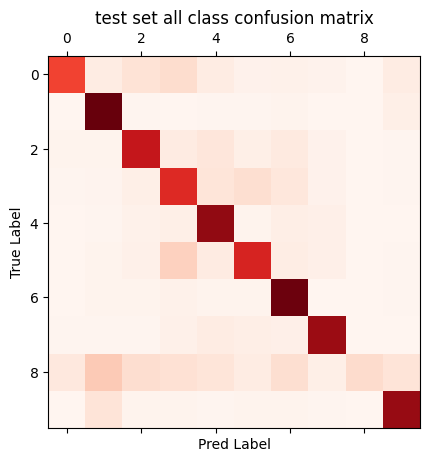

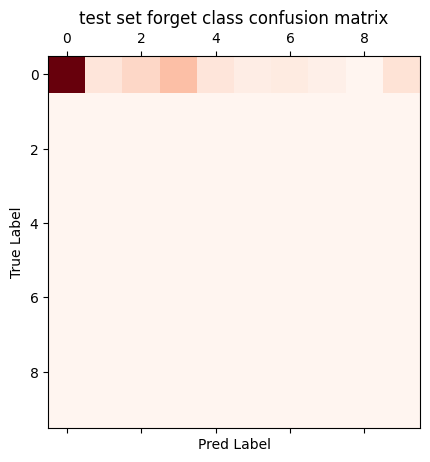

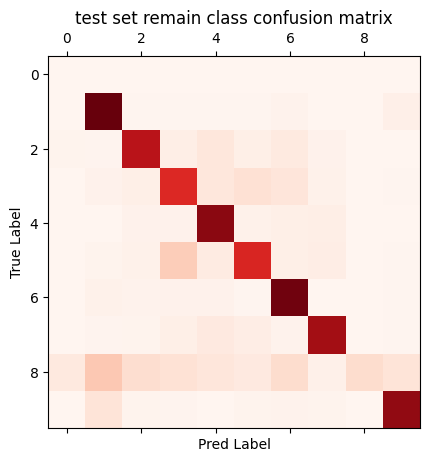

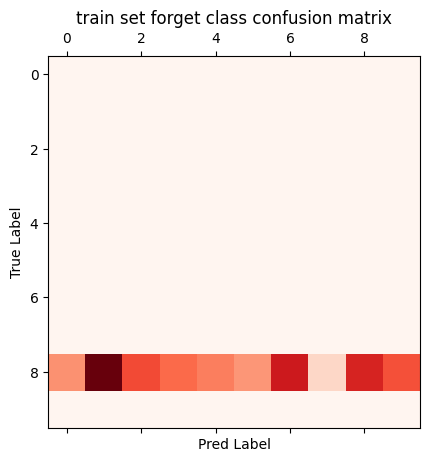

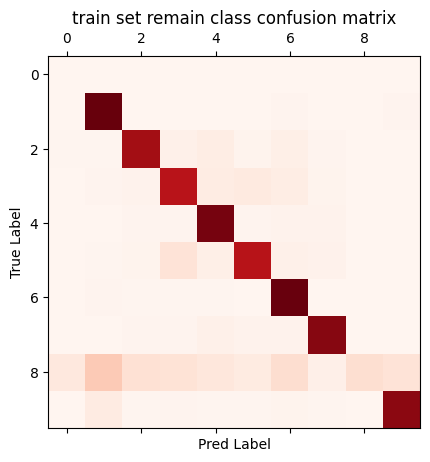

test acc:71.09%, forget acc:54.90%, remain acc:72.46%, train forget acc:13.08%, train remain acc:80.50%
Time Consuming: 178.874986410141 secs


100%|██████████| 400/400 [01:33<00:00,  4.29it/s]


attack success ratio: tensor(1., device='cuda:0')
boundary shrink time: 93.24713778495789


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


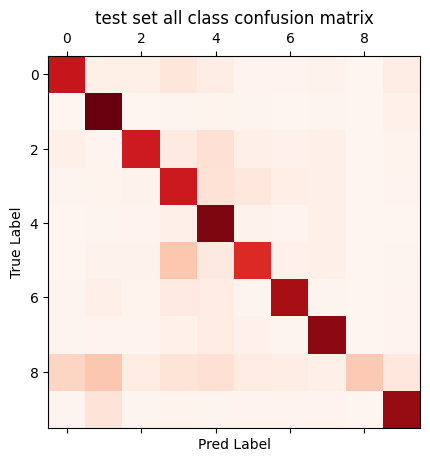

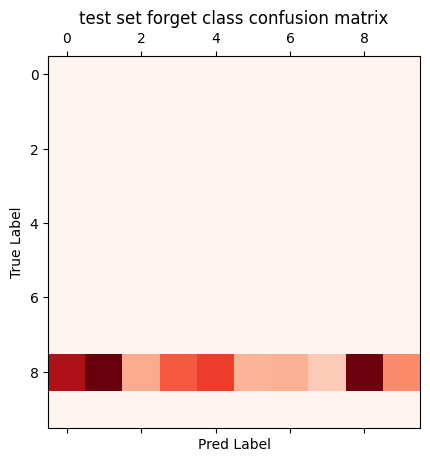

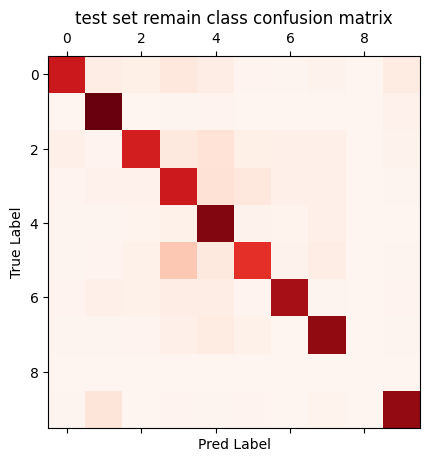

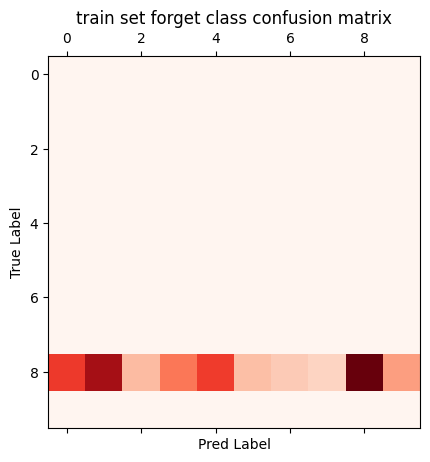

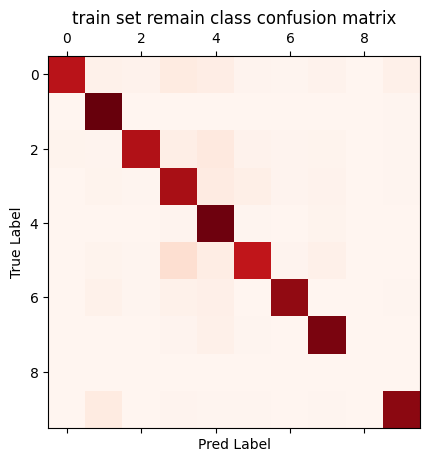

test acc:73.21%, forget acc:18.10%, remain acc:79.34%, train forget acc:20.96%, train remain acc:88.02%
Time Consuming: 212.85678958892822 secs


In [69]:
bound=8
step=1 / 255
iter=50

half_unlearn_model_2_class = boundary_shrink(origin_model, half_train_forget_loader, train_dataset, test_dataset, test_loader, device, evaluation, forget_class=forget_classes[0], path='./half_2_', extra_exp=extra_exp, bound=bound, iter=iter, step=step)
half_unlearn_model_2_class = boundary_shrink(half_unlearn_model_2_class, half_train_forget_loader, train_dataset, test_dataset, test_loader, device, evaluation, forget_class=forget_classes[1], path='./half_2_', extra_exp=extra_exp, bound=bound, iter=iter, step=step)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


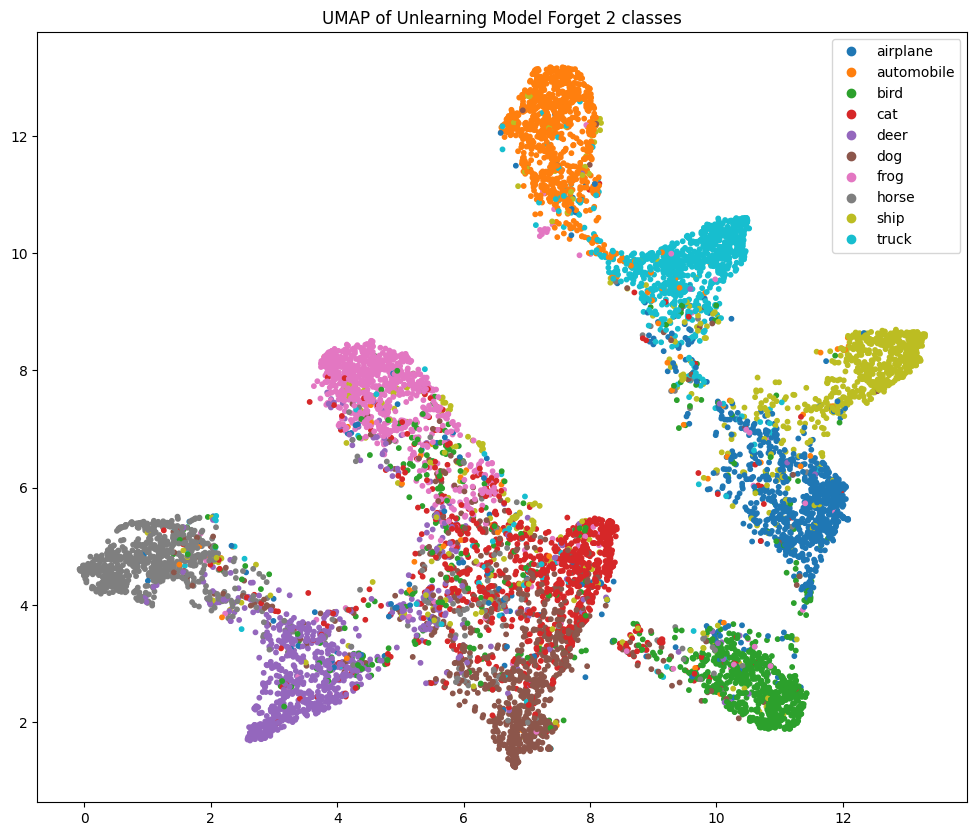

In [70]:
import umap

def get_intermediate_features(input_model, input, layer_name='avgpool'):
    def hook(module, input, output):
        features.append(output.detach().cpu().numpy())
    features = []
    handle = input_model._modules.get(layer_name).register_forward_hook(hook)
    input_model(input)
    handle.remove()
    return features[0]


all_features = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        features = get_intermediate_features(half_unlearn_model_2_class, images)  # Feature extraction from avgpool layer
        features = features.reshape(features.shape[0], -1)
        all_features.append(features)
        all_labels.append(labels.numpy())

all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)


reducer = umap.UMAP(n_components=2, random_state=42, min_dist=0.01)
umap_embedding = reducer.fit_transform(all_features)

# 시각화
plt.figure(figsize=(12, 10))
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=all_labels, cmap='tab10', s=10)
plt.legend(handles=scatter.legend_elements()[0], labels=test_dataset.classes)
plt.title('UMAP of Unlearning Model Forget 2 classes')
plt.show()

In [71]:
def calculate_retain_accuracy(class_acc, retain_classes):
    retain_acc = 0
    for i in retain_classes:
        retain_acc += class_acc[i]
    return retain_acc / len(retain_classes)

def calculate_forget_accuracy(class_acc, forget_classes):
    forget_acc = 0
    for i in forget_classes:
        forget_acc += class_acc[i]
    return forget_acc / len(forget_classes)

half_unlearn_train_retain_acc, half_unlearn_train_retain_class_acc = evaluate(train_remain_loader, half_unlearn_model_2_class)
half_unlearn_train_forget_acc, half_unlearn_train_forget_class_acc = evaluate(train_forget_loader, half_unlearn_model_2_class)
half_unlearn_test_retain_acc, half_unlearn_test_retain_class_acc = evaluate(test_remain_loader, half_unlearn_model_2_class)
half_unlearn_test_forget_acc, half_unlearn_test_forget_class_acc = evaluate(test_forget_loader, half_unlearn_model_2_class)

print(f'Accuracy of train retain: {calculate_retain_accuracy(half_unlearn_train_retain_class_acc, retain_classes)}')
print(f'Accuracy of train forget: {calculate_forget_accuracy(half_unlearn_train_forget_class_acc, forget_classes)}')
print(f'Accuracy of test retain: {calculate_retain_accuracy(half_unlearn_test_retain_class_acc, retain_classes)}')
print(f'Accuracy of test forget: {calculate_forget_accuracy(half_unlearn_test_forget_class_acc, forget_classes)}')

print("Accuray of each class in training retain set:")
for i in retain_classes:
    print(f'Accuracy of {classes[i]} : {half_unlearn_train_retain_class_acc[i]} %')

print("Accuray of each class in training forget set:")
for i in forget_classes:
  print(f'Accuracy of {classes[i]} : {half_unlearn_train_forget_class_acc[i]} %')

print("Accuray of each class in test retain set:")
for i in retain_classes:
    print(f'Accuracy of {classes[i]} : {half_unlearn_test_retain_class_acc[i]} %')

print("Accuray of each class in test forget set:")
for i in forget_classes:
  print(f'Accuracy of {classes[i]} : {half_unlearn_test_forget_class_acc[i]} %')


Accuracy of train retain: 89.33250000000001
Accuracy of train forget: 9.57
Accuracy of test retain: 80.12500000000001
Accuracy of test forget: 9.6
Accuray of each class in training retain set:
Accuracy of car : 98.76 %
Accuracy of bird : 81.44 %
Accuracy of cat : 84.98 %
Accuracy of deer : 96.54 %
Accuracy of dog : 77.22 %
Accuracy of frog : 90.02 %
Accuracy of horse : 94.86 %
Accuracy of truck : 90.84 %
Accuray of each class in training forget set:
Accuracy of airplane : 0 %
Accuracy of ship : 19.14 %
Accuray of each class in test retain set:
Accuracy of car : 94.7 %
Accuracy of bird : 69.5 %
Accuracy of cat : 70.4 %
Accuracy of deer : 89.5 %
Accuracy of dog : 63.5 %
Accuracy of frog : 82.0 %
Accuracy of horse : 86.7 %
Accuracy of truck : 84.7 %
Accuray of each class in test forget set:
Accuracy of airplane : 0 %
Accuracy of ship : 19.2 %


### 100% of Images

100%|██████████| 790/790 [03:47<00:00,  3.47it/s]


attack success ratio: tensor(1., device='cuda:0')
boundary shrink time: 227.72948813438416


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


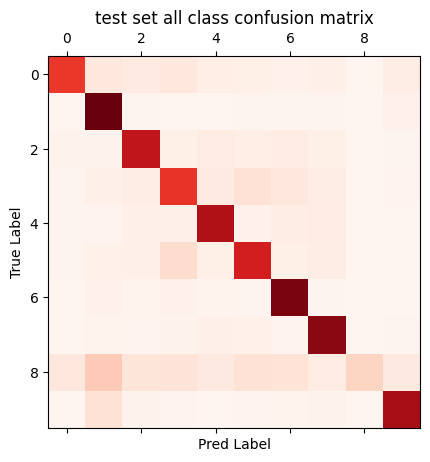

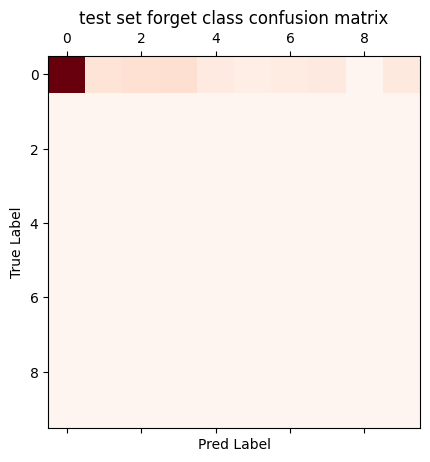

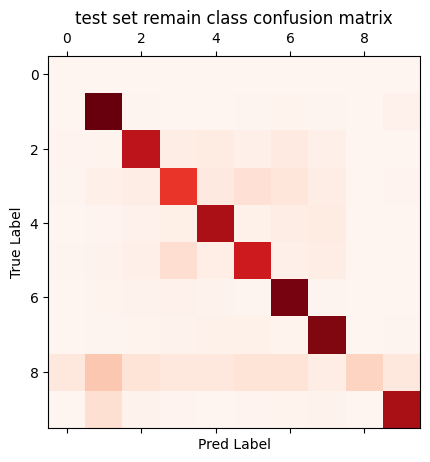

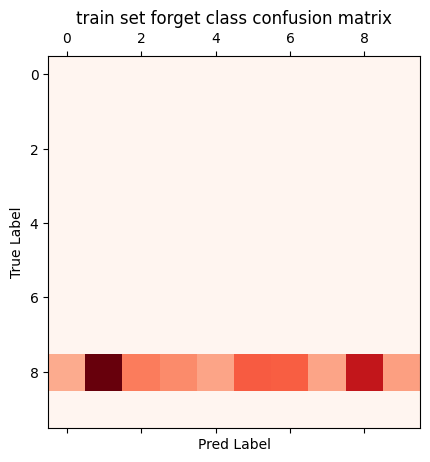

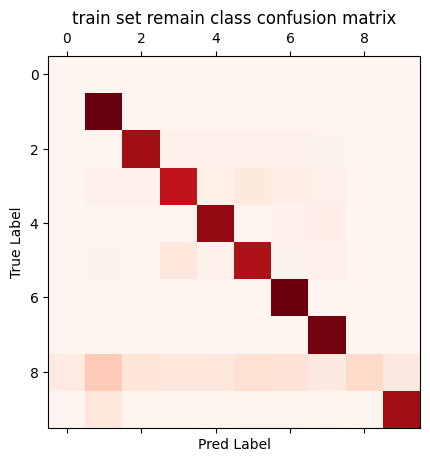

test acc:72.01%, forget acc:60.60%, remain acc:73.51%, train forget acc:15.66%, train remain acc:80.84%
Time Consuming: 386.4668378829956 secs


100%|██████████| 790/790 [04:01<00:00,  3.28it/s]


attack success ratio: tensor(1., device='cuda:0')
boundary shrink time: 241.02704524993896


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


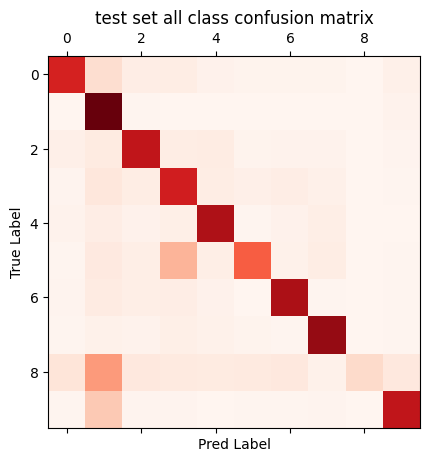

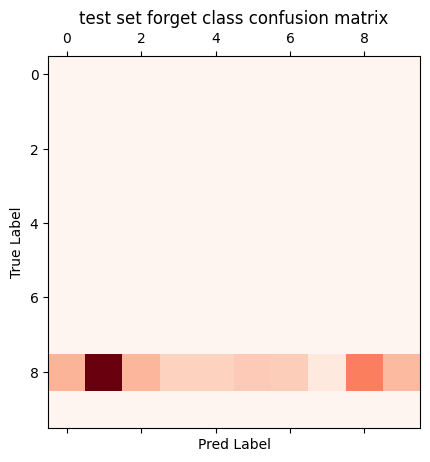

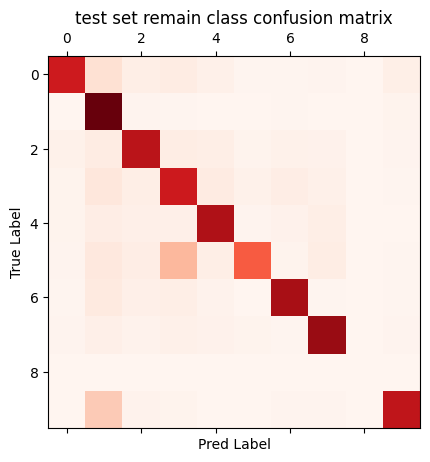

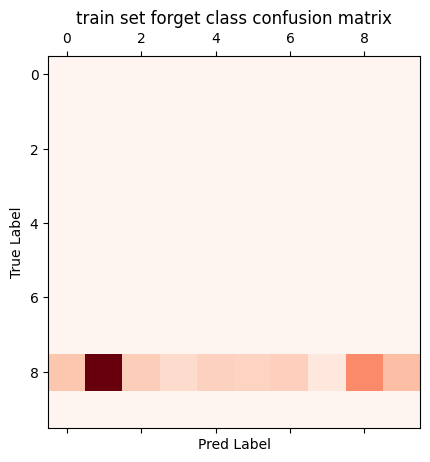

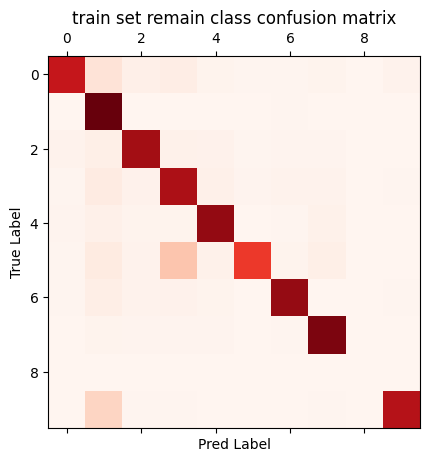

test acc:70.31%, forget acc:14.40%, remain acc:77.08%, train forget acc:14.46%, train remain acc:84.84%
Time Consuming: 328.89622473716736 secs


In [72]:
bound=8
step=1 / 255
iter=50

unlearn_model_2_class = boundary_shrink(origin_model, train_forget_loader, train_dataset, test_dataset, test_loader, device, evaluation, forget_class=forget_classes[0], path='./all_2_', extra_exp=extra_exp, bound=bound, iter=iter, step=step)
unlearn_model_2_class = boundary_shrink(unlearn_model_2_class, train_forget_loader, train_dataset, test_dataset, test_loader, device, evaluation, forget_class=forget_classes[1], path='./all_2_', extra_exp=extra_exp, bound=bound, iter=iter, step=step)

In [73]:
def calculate_retain_accuracy(class_acc, retain_classes):
    retain_acc = 0
    for i in retain_classes:
        retain_acc += class_acc[i]
    return retain_acc / len(retain_classes)

def calculate_forget_accuracy(class_acc, forget_classes):
    forget_acc = 0
    for i in forget_classes:
        forget_acc += class_acc[i]
    return forget_acc / len(forget_classes)

unlearn_train_retain_acc, unlearn_train_retain_class_acc = evaluate(train_remain_loader, unlearn_model_2_class)
unlearn_train_forget_acc, unlearn_train_forget_class_acc = evaluate(train_forget_loader, unlearn_model_2_class)
unlearn_test_retain_acc, unlearn_test_retain_class_acc = evaluate(test_remain_loader, unlearn_model_2_class)
unlearn_test_forget_acc, unlearn_test_forget_class_acc = evaluate(test_forget_loader, unlearn_model_2_class)

print(f'Accuracy of train retain: {calculate_retain_accuracy(unlearn_train_retain_class_acc, retain_classes)}')
print(f'Accuracy of train forget: {calculate_forget_accuracy(unlearn_train_forget_class_acc, forget_classes)}')
print(f'Accuracy of test retain: {calculate_retain_accuracy(unlearn_test_retain_class_acc, retain_classes)}')
print(f'Accuracy of test forget: {calculate_forget_accuracy(unlearn_test_forget_class_acc, forget_classes)}')

print("Accuray of each class in training retain set:")
for i in retain_classes:
    print(f'Accuracy of {classes[i]} : {unlearn_train_retain_class_acc[i]} %')

print("Accuray of each class in training forget set:")
for i in forget_classes:
  print(f'Accuracy of {classes[i]} : {unlearn_train_forget_class_acc[i]} %')

print("Accuray of each class in test retain set:")
for i in retain_classes:
    print(f'Accuracy of {classes[i]} : {unlearn_test_retain_class_acc[i]} %')

print("Accuray of each class in test forget set:")
for i in forget_classes:
  print(f'Accuracy of {classes[i]} : {unlearn_test_forget_class_acc[i]} %')


Accuracy of train retain: 85.8875
Accuracy of train forget: 7.17
Accuracy of test retain: 77.55
Accuracy of test forget: 6.75
Accuray of each class in training retain set:
Accuracy of car : 99.04 %
Accuracy of bird : 87.64 %
Accuracy of cat : 83.8 %
Accuracy of deer : 90.32 %
Accuracy of dog : 62.86 %
Accuracy of frog : 88.7 %
Accuracy of horse : 93.66 %
Accuracy of truck : 81.08 %
Accuray of each class in training forget set:
Accuracy of airplane : 0 %
Accuracy of ship : 14.34 %
Accuray of each class in test retain set:
Accuracy of car : 96.4 %
Accuracy of bird : 75.6 %
Accuracy of cat : 69.9 %
Accuracy of deer : 81.0 %
Accuracy of dog : 52.6 %
Accuracy of frog : 82.8 %
Accuracy of horse : 85.7 %
Accuracy of truck : 76.4 %
Accuray of each class in test forget set:
Accuracy of airplane : 0 %
Accuracy of ship : 13.5 %


## 6.4 Result Comparion and Analysis

In [74]:
# 2. Retrain Model
retrain_model = torchvision.models.resnet18(pretrained=False)
retrain_model.fc = nn.Linear(model.fc.in_features, 10)
retrain_model.load_state_dict(torch.load('cifar10_retrain_2_resnet18.pth'))
retrain_model.to(device)

retrain_train_retain_acc, retrain_train_retain_class_acc = evaluate(train_remain_loader, retrain_model)
retrain_train_forget_acc, retrain_train_forget_class_acc = evaluate(train_forget_loader, retrain_model)
retrain_test_retain_acc, retrain_test_retain_class_acc = evaluate(test_remain_loader, retrain_model)
retrain_test_forget_acc, retrain_test_forget_class_acc = evaluate(test_forget_loader, retrain_model)

print(f'Accuracy of train retain: {calculate_retain_accuracy(retrain_train_retain_class_acc, retain_classes)}')
print(f'Accuracy of train forget: {calculate_forget_accuracy(retrain_train_forget_class_acc, forget_classes)}')
print(f'Accuracy of test retain: {calculate_retain_accuracy(retrain_test_retain_class_acc, retain_classes)}')
print(f'Accuracy of test forget: {calculate_forget_accuracy(retrain_test_forget_class_acc, forget_classes)}')


print("Accuray of each class in training retain set:")
for i in retain_classes:
    print(f'Accuracy of {classes[i]} : {retrain_train_retain_class_acc[i]} %')

print("Accuray of each class in training forget set:")
for i in forget_classes:
  print(f'Accuracy of {classes[i]} : {retrain_train_forget_class_acc[i]} %')

print("Accuray of each class in test retain set:")
for i in retain_classes:
    print(f'Accuracy of {classes[i]} : {retrain_test_retain_class_acc[i]} %')

print("Accuray of each class in test forget set:")
for i in forget_classes:
  print(f'Accuracy of {classes[i]} : {retrain_test_forget_class_acc[i]} %')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Accuracy of train retain: 97.91000000000001
Accuracy of train forget: 0.0
Accuracy of test retain: 86.05000000000001
Accuracy of test forget: 0.0
Accuray of each class in training retain set:
Accuracy of car : 99.1 %
Accuracy of bird : 98.32 %
Accuracy of cat : 95.36 %
Accuracy of deer : 98.06 %
Accuracy of dog : 96.42 %
Accuracy of frog : 98.68 %
Accuracy of horse : 98.26 %
Accuracy of truck : 99.08 %
Accuray of each class in training forget set:
Accuracy of airplane : 0 %
Accuracy of ship : 0.0 %
Accuray of each class in test retain set:
Accuracy of car : 94.1 %
Accuracy of bird : 85.2 %
Accuracy of cat : 73.9 %
Accuracy of deer : 85.7 %
Accuracy of dog : 78.3 %
Accuracy of frog : 90.1 %
Accuracy of horse : 88.6 %
Accuracy of truck : 92.5 %
Accuray of each class in test forget set:
Accuracy of airplane : 0 %
Accuracy of ship : 0.0 %


In [75]:
# 3. Random Model
random_model = torchvision.models.resnet18(pretrained=False)
random_model.fc = nn.Linear(model.fc.in_features, 10)
random_model.load_state_dict(torch.load('cifar10_random_2_resnet18.pth'))
random_model.to(device)

random_train_retain_acc, random_train_retain_class_acc = evaluate(train_remain_loader, random_model)
random_train_forget_acc, random_train_forget_class_acc = evaluate(train_forget_loader, random_model)
random_test_retain_acc, random_test_retain_class_acc = evaluate(test_remain_loader, random_model)
random_test_forget_acc, random_test_forget_class_acc = evaluate(test_forget_loader, random_model)

print(f'Accuracy of train retain: {calculate_retain_accuracy(random_train_retain_class_acc, retain_classes)}')
print(f'Accuracy of train forget: {calculate_forget_accuracy(random_train_forget_class_acc, forget_classes)}')
print(f'Accuracy of test retain: {calculate_retain_accuracy(random_test_retain_class_acc, retain_classes)}')
print(f'Accuracy of test forget: {calculate_forget_accuracy(random_test_forget_class_acc, forget_classes)}')


print("Accuray of each class in training retain set:")
for i in retain_classes:
    print(f'Accuracy of {classes[i]} : {random_train_retain_class_acc[i]} %')

print("Accuray of each class in training forget set:")
for i in forget_classes:
  print(f'Accuracy of {classes[i]} : {random_train_forget_class_acc[i]} %')

print("Accuray of each class in test retain set:")
for i in retain_classes:
    print(f'Accuracy of {classes[i]} : {random_test_retain_class_acc[i]} %')

print("Accuray of each class in test forget set:")
for i in forget_classes:
  print(f'Accuracy of {classes[i]} : {random_test_forget_class_acc[i]} %')

Accuracy of train retain: 97.155
Accuracy of train forget: 0.0
Accuracy of test retain: 85.7125
Accuracy of test forget: 0.0
Accuray of each class in training retain set:
Accuracy of car : 98.74 %
Accuracy of bird : 96.74 %
Accuracy of cat : 93.88 %
Accuracy of deer : 97.52 %
Accuracy of dog : 95.08 %
Accuracy of frog : 98.4 %
Accuracy of horse : 98.32 %
Accuracy of truck : 98.56 %
Accuray of each class in training forget set:
Accuracy of airplane : 0 %
Accuracy of ship : 0.0 %
Accuray of each class in test retain set:
Accuracy of car : 92.2 %
Accuracy of bird : 82.3 %
Accuracy of cat : 73.9 %
Accuracy of deer : 86.1 %
Accuracy of dog : 78.2 %
Accuracy of frog : 92.1 %
Accuracy of horse : 89.7 %
Accuracy of truck : 91.2 %
Accuray of each class in test forget set:
Accuracy of airplane : 0 %
Accuracy of ship : 0.0 %


The results of original model and boundary shrink model are already calculated. You can check Q1 and 6.3. I don't have time to recalculate performance.